In [22]:
import torch
print('PyTorch version:', torch.__version__)
from torch import nn
from torch import optim
from torch.utils.data import DataLoader

import torchvision
print('Torchvision version:', torchvision.__version__)
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import make_grid

from tqdm import tqdm
from torchinfo import summary

import numpy as np
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder

PyTorch version: 2.2.2+cu121
Torchvision version: 0.17.2+cu121


In [23]:
print('GPU name:', torch.cuda.get_device_name(), '\n')
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device is:', device, '\n')
print('Total number of GPUs:', torch.cuda.device_count())

GPU name: NVIDIA GeForce RTX 3060 

Device is: cuda 

Total number of GPUs: 1


In [24]:
# Define the paths for your training and test datasets
train_path = "YourPath"
test_path = "YourPath"

In [25]:
# Define the transformations to be applied to the images
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.Grayscale(), 
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

In [26]:
# Load the training dataset
training_dataset = ImageFolder(root=train_path, transform=transform)

# Load the test dataset
test_dataset = ImageFolder(root=test_path, transform=transform)

In [27]:
# Load a sample image from the dataset
sample_image, _ = training_dataset[0]

# Check the shape of the sample image
print("Sample image shape:", sample_image.shape)

Sample image shape: torch.Size([1, 32, 32])


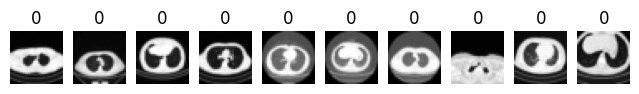

In [28]:
# Show 10 randomly selected samples from the training dataset
fig, axis = plt.subplots(nrows=1, ncols=10, figsize=(8, 1))

for ax, _ in zip(axis.ravel(), range(10)):
    inx = np.random.randint(len(training_dataset))
    ax.imshow(training_dataset[inx][0].permute(1, 2, 0), cmap='gray')
    ax.set_title(int(training_dataset[inx][1]), fontsize=12)
    ax.axis(False)

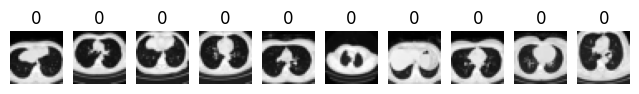

In [29]:
# Show 10 randomly selected samples from the test dataset
fig, axis = plt.subplots(nrows=1, ncols=10, figsize=(8, 1))

for ax, _ in zip(axis.ravel(), range(10)):
    inx = np.random.randint(len(test_dataset))
    ax.imshow(test_dataset[inx][0].permute(1, 2, 0), cmap='gray')
    ax.set_title(int(test_dataset[inx][1]), fontsize=12)
    ax.axis(False)


In [30]:
training_dataloader = DataLoader(training_dataset, batch_size=64, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, drop_last=True)

In [31]:
class Linear_Variance_Scheduler:
    def __init__(self, time_steps, beta_start, beta_end, device='cuda'):
        
        self.time_steps = time_steps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.device = device
        
        self.betas = torch.linspace(self.beta_start, self.beta_end, self.time_steps).to(self.device)
        self.alphas = 1 - self.betas
        self.alpha_bar = torch.cumprod(self.alphas, dim=0)
        self.sqrt_alpha_bar = torch.sqrt(self.alpha_bar)
        self.sqrt_one_minus_alpha_bar = torch.sqrt(1 - self.alpha_bar)
        
    def diffusion_process(self, x, noise, t):
        sqrt_alpha_bar = self.sqrt_alpha_bar[t][:, None, None, None]
        sqrt_one_minus_alpha_bar = self.sqrt_one_minus_alpha_bar[t][:, None, None, None]
        return sqrt_alpha_bar * x + sqrt_one_minus_alpha_bar * noise
    
    def ddpm_sampling(self, model, num_samples, channels, img_size):
        model.eval()
        with torch.inference_mode():
            x = torch.randn((num_samples, channels, img_size, img_size)).to(self.device)
            collect = []
            for i in tqdm(reversed(range(self.time_steps))):
                t = (torch.ones(num_samples) * i).long().to(self.device)
                pred_noise = model(x, t)
                alphas = self.alphas[t][:, None, None, None]
                alpha_bar = self.alpha_bar[t][:, None, None, None]
                betas = self.betas[t][:, None, None, None]
                if i > 1:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)
                x = 1 / torch.sqrt(alphas) * (x - ((1 - alphas) / (torch.sqrt(1 - alpha_bar))) * pred_noise) +\
                    torch.sqrt(betas) * noise
                if (i+1) % 100 == 0 or i==0:
                    collect.append(x)
        return x, collect

In [32]:
t_step = torch.linspace(start=0, end=1000-1, steps=11).long()
get_img = training_dataset[0][0]

get_img_stack = torch.stack([get_img]*11)
get_noise_stack = torch.randn_like(get_img_stack)

In [33]:
noisy_img_stack = Linear_Variance_Scheduler(time_steps=1000, beta_start=0.0001, beta_end=0.02,
                                            device='cpu').diffusion_process(get_img_stack, get_noise_stack, t_step)

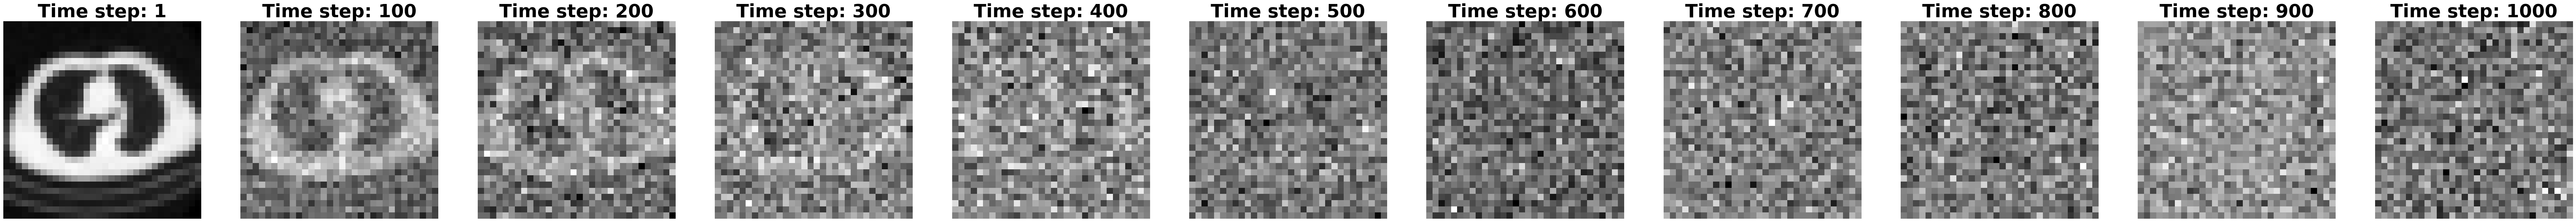

In [34]:
fig, ax = plt.subplots(nrows=1, ncols=11, figsize=(100, 100))

for idx, img in enumerate(noisy_img_stack):
    #ax[idx].imshow(img.squeeze(), cmap='gray')
    ax[idx].imshow(img.permute(1, 2, 0), cmap='gray')
    ax[idx].set_title(f'Time step: {t_step[idx]+1}', fontsize=40, fontweight='bold')
    ax[idx].axis(False);

In [35]:
class ResBlock(nn.Module):
    def __init__(self, inp_ch, out_ch, mid_ch=None, residual=False):
        super(ResBlock, self).__init__()
        
        self.residual = residual
        if not mid_ch:
            mid_ch = out_ch
        self.resnet_conv = nn.Sequential()
        self.resnet_conv.add_module('conv1', nn.Conv2d(in_channels=inp_ch, out_channels=mid_ch, kernel_size=3, stride=1,
                                                       padding=1))
        self.resnet_conv.add_module('gnor1', nn.GroupNorm(num_groups=8, num_channels=mid_ch))
        self.resnet_conv.add_module('silu1', nn.SiLU())
        self.resnet_conv.add_module('conv2', nn.Conv2d(in_channels=mid_ch, out_channels=out_ch, kernel_size=3, stride=1,
                                                       padding=1))
        self.resnet_conv.add_module('gnor2', nn.GroupNorm(num_groups=8, num_channels=out_ch))
        
    def forward(self, x):
        if self.residual:
            return x + self.resnet_conv(x)
        else:
            return self.resnet_conv(x)

In [36]:
class SelfAttentionBlock(nn.Module):
    def __init__(self, channels):
        super(SelfAttentionBlock, self).__init__()
        
        self.attn_norm = nn.GroupNorm(num_groups=8, num_channels=channels)
        self.mha = nn.MultiheadAttention(embed_dim=channels, num_heads=4, batch_first=True)
        
    def forward(self, x):
        b, c, h, w = x.shape
        inp_attn = x.reshape(b, c, h*w)
        inp_attn = self.attn_norm(inp_attn)
        inp_attn = inp_attn.transpose(1, 2)
        out_attn, _ = self.mha(inp_attn, inp_attn, inp_attn)
        out_attn = out_attn.transpose(1, 2).reshape(b, c, h, w)
        return x + out_attn

In [37]:
class DownBlock(nn.Module):
    def __init__(self, inp_ch, out_ch, t_emb_dim=256):
        super(DownBlock, self).__init__()
        
        self.down = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            ResBlock(inp_ch=inp_ch, out_ch=inp_ch, residual=True),
            ResBlock(inp_ch=inp_ch, out_ch=out_ch)
        )
        
        self.t_emb_layers = nn.Sequential()
        self.t_emb_layers.add_module('silu1', nn.SiLU())
        self.t_emb_layers.add_module('linr1', nn.Linear(in_features=t_emb_dim, out_features=out_ch))
        
    def forward(self, x, t):
        x = self.down(x)
        t_emb = self.t_emb_layers(t)[:, :, None, None].repeat(1, 1, x.shape[2], x.shape[3])
        return x + t_emb

In [38]:
class UpBlock(nn.Module):
    def __init__(self, inp_ch, out_ch, t_emb_dim=256):
        super(UpBlock, self).__init__()
        
        self.upsamp = nn.UpsamplingBilinear2d(scale_factor=2)
        self.up = nn.Sequential(
            ResBlock(inp_ch=inp_ch, out_ch=inp_ch, residual=True),
            ResBlock(inp_ch=inp_ch, out_ch=out_ch, mid_ch=inp_ch//2)
        )
        
        self.t_emb_layers = nn.Sequential()
        self.t_emb_layers.add_module('silu1', nn.SiLU())
        self.t_emb_layers.add_module('linr1', nn.Linear(in_features=t_emb_dim, out_features=out_ch))
        
    def forward(self, x, skip, t):
        x = self.upsamp(x)
        x = torch.cat([skip, x], dim=1)
        x = self.up(x)
        t_emb = self.t_emb_layers(t)[:, :, None, None].repeat(1, 1, x.shape[2], x.shape[3])
        return x + t_emb

In [39]:
class UNet(nn.Module):
    def __init__(self, t_emb_dim, device='cuda'):
        super(UNet, self).__init__()
        
        self.device = device
        self.t_emb_dim = t_emb_dim
        
        self.inp = ResBlock(inp_ch=1, out_ch=64)
        self.down1 = DownBlock(inp_ch=64, out_ch=128)
        self.sa1 = SelfAttentionBlock(channels=128)
        self.down2 = DownBlock(inp_ch=128, out_ch=256)
        self.sa2 = SelfAttentionBlock(channels=256)
        self.down3 = DownBlock(inp_ch=256, out_ch=256)
        self.sa3 = SelfAttentionBlock(channels=256)
        
        self.lat1 = ResBlock(inp_ch=256, out_ch=512)
        self.lat2 = ResBlock(inp_ch=512, out_ch=512)
        self.lat3 = ResBlock(inp_ch=512, out_ch=256)
        
        self.up1 = UpBlock(inp_ch=512, out_ch=128)
        self.sa4 = SelfAttentionBlock(channels=128)
        self.up2 = UpBlock(inp_ch=256, out_ch=64)
        self.sa5 = SelfAttentionBlock(channels=64)
        self.up3 = UpBlock(inp_ch=128, out_ch=64)
        self.sa6 = SelfAttentionBlock(channels=64)
        
        self.out = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1)
        
    def position_embeddings(self, t, channels):
        i = 1 / (10000 ** (torch.arange(start=0, end=channels, step=2, device=self.device) / channels))
        pos_emb_sin = torch.sin(t.repeat(1, channels//2) * i)
        pos_emb_cos = torch.cos(t.repeat(1, channels//2) * i)
        pos_emb = torch.cat([pos_emb_sin, pos_emb_cos], dim=-1)
        return pos_emb
    
    def forward(self, x, t):
        t = t.unsqueeze(1).float()
        t = self.position_embeddings(t, self.t_emb_dim)
        
        x1 = self.inp(x)
        x2 = self.down1(x1, t)
        x2 = self.sa1(x2)
        x3 = self.down2(x2, t)
        x3 = self.sa2(x3)
        x4 = self.down3(x3, t)
        x4 = self.sa3(x4)
        
        x4 = self.lat1(x4)
        x4 = self.lat2(x4)
        x4 = self.lat3(x4)
        
        x = self.up1(x4, x3, t)
        x = self.sa4(x)
        x = self.up2(x, x2, t)
        x = self.sa5(x)
        x = self.up3(x, x1, t)
        x = self.sa6(x)
        output = self.out(x)
        return output

In [40]:
summary(UNet(t_emb_dim=256), input_size=[(64, 1, 32, 32), (64,)])
#summary(UNet(t_emb_dim=256), input_size=[(64, 1, 128, 128), (64,)])

Layer (type:depth-idx)                        Output Shape              Param #
UNet                                          [64, 1, 32, 32]           --
├─ResBlock: 1-1                               [64, 64, 32, 32]          --
│    └─Sequential: 2-1                        [64, 64, 32, 32]          --
│    │    └─Conv2d: 3-1                       [64, 64, 32, 32]          640
│    │    └─GroupNorm: 3-2                    [64, 64, 32, 32]          128
│    │    └─SiLU: 3-3                         [64, 64, 32, 32]          --
│    │    └─Conv2d: 3-4                       [64, 64, 32, 32]          36,928
│    │    └─GroupNorm: 3-5                    [64, 64, 32, 32]          128
├─DownBlock: 1-2                              [64, 128, 16, 16]         --
│    └─Sequential: 2-2                        [64, 128, 16, 16]         --
│    │    └─MaxPool2d: 3-6                    [64, 64, 16, 16]          --
│    │    └─ResBlock: 3-7                     [64, 64, 16, 16]          74,112
│    │   

In [41]:
ddpm = Linear_Variance_Scheduler(time_steps=1000, beta_start=0.0001, beta_end=0.02)
model = UNet(t_emb_dim=256).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [42]:
torch.manual_seed(1111)
torch.cuda.manual_seed(1111)
torch.cuda.manual_seed_all(1111)
np.random.seed(1111)

n_epochs = 1000
training_loss, test_loss = [], []

for epoch in range(n_epochs):
    training_losses, test_losses = [], []
    
    for data, _ in tqdm(training_dataloader):
        model.train()
        data = data.to(device)
        t = torch.randint(low=0, high=1000, size=(data.shape[0],)).to(device)
        noise = torch.randn_like(data)
        xt = ddpm.diffusion_process(x=data, noise=noise, t=t)
        pred_noise = model(xt, t)
        trng_batch_loss = criterion(noise, pred_noise)
        optimizer.zero_grad()
        trng_batch_loss.backward()
        optimizer.step()
        training_losses.append(trng_batch_loss.item())
    training_per_epoch_loss = np.array(training_losses).mean()
    
    with torch.inference_mode():
        for data, _ in tqdm(test_dataloader):
            model.eval()
            data = data.to(device)
            t = torch.randint(low=0, high=1000, size=(data.shape[0],)).to(device)
            noise = torch.randn_like(data)
            xt = ddpm.diffusion_process(x=data, noise=noise, t=t)
            pred_noise = model(xt, t)
            tst_batch_loss = criterion(noise, pred_noise)
            test_losses.append(tst_batch_loss.item())
        test_per_epoch_loss = np.array(test_losses).mean()
        
    training_loss.append(training_per_epoch_loss)
    test_loss.append(test_per_epoch_loss)
    
    print(f'Epoch: {epoch+1}/{n_epochs}\t| Training loss: {training_per_epoch_loss:.4f} |   ', end='')
    print(f'Test loss: {test_per_epoch_loss:.4f}')

100%|██████████| 20/20 [00:03<00:00,  6.29it/s]


Epoch: 1/1000	| Training loss: 0.2397 |   Test loss: 0.1532


100%|██████████| 20/20 [00:03<00:00,  6.34it/s]


Epoch: 2/1000	| Training loss: 0.1214 |   Test loss: 0.1169


100%|██████████| 20/20 [00:03<00:00,  6.34it/s]


Epoch: 3/1000	| Training loss: 0.0915 |   Test loss: 0.0930


100%|██████████| 20/20 [00:03<00:00,  6.34it/s]


Epoch: 4/1000	| Training loss: 0.0735 |   Test loss: 0.0780


100%|██████████| 20/20 [00:01<00:00, 11.30it/s]


Epoch: 5/1000	| Training loss: 0.0654 |   Test loss: 0.0752


100%|██████████| 20/20 [00:01<00:00, 11.30it/s]


Epoch: 6/1000	| Training loss: 0.0601 |   Test loss: 0.0667


100%|██████████| 20/20 [00:01<00:00, 11.38it/s]


Epoch: 7/1000	| Training loss: 0.0572 |   Test loss: 0.0658


100%|██████████| 20/20 [00:01<00:00, 11.33it/s]


Epoch: 8/1000	| Training loss: 0.0511 |   Test loss: 0.0667


100%|██████████| 20/20 [00:01<00:00, 11.31it/s]


Epoch: 9/1000	| Training loss: 0.0488 |   Test loss: 0.0687


100%|██████████| 20/20 [00:01<00:00, 11.31it/s]


Epoch: 10/1000	| Training loss: 0.0458 |   Test loss: 0.0605


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 11/1000	| Training loss: 0.0451 |   Test loss: 0.0594


100%|██████████| 20/20 [00:01<00:00, 11.26it/s]


Epoch: 12/1000	| Training loss: 0.0439 |   Test loss: 0.0654


100%|██████████| 20/20 [00:01<00:00, 11.26it/s]


Epoch: 13/1000	| Training loss: 0.0422 |   Test loss: 0.0561


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 14/1000	| Training loss: 0.0424 |   Test loss: 0.0535


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 15/1000	| Training loss: 0.0396 |   Test loss: 0.0513


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 16/1000	| Training loss: 0.0396 |   Test loss: 0.0575


100%|██████████| 20/20 [00:01<00:00, 11.25it/s]


Epoch: 17/1000	| Training loss: 0.0367 |   Test loss: 0.0506


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 18/1000	| Training loss: 0.0385 |   Test loss: 0.0543


100%|██████████| 20/20 [00:01<00:00, 11.26it/s]


Epoch: 19/1000	| Training loss: 0.0362 |   Test loss: 0.0498


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 20/1000	| Training loss: 0.0383 |   Test loss: 0.0517


100%|██████████| 20/20 [00:01<00:00, 11.26it/s]


Epoch: 21/1000	| Training loss: 0.0362 |   Test loss: 0.0471


100%|██████████| 20/20 [00:01<00:00, 11.25it/s]


Epoch: 22/1000	| Training loss: 0.0339 |   Test loss: 0.0494


100%|██████████| 20/20 [00:01<00:00, 11.26it/s]


Epoch: 23/1000	| Training loss: 0.0332 |   Test loss: 0.0508


100%|██████████| 20/20 [00:01<00:00, 11.29it/s]


Epoch: 24/1000	| Training loss: 0.0339 |   Test loss: 0.0508


100%|██████████| 20/20 [00:01<00:00, 11.26it/s]


Epoch: 25/1000	| Training loss: 0.0345 |   Test loss: 0.0517


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 26/1000	| Training loss: 0.0319 |   Test loss: 0.0481


100%|██████████| 20/20 [00:01<00:00, 11.26it/s]


Epoch: 27/1000	| Training loss: 0.0312 |   Test loss: 0.0476


100%|██████████| 20/20 [00:01<00:00, 11.25it/s]


Epoch: 28/1000	| Training loss: 0.0327 |   Test loss: 0.0556


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 29/1000	| Training loss: 0.0290 |   Test loss: 0.0461


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 30/1000	| Training loss: 0.0301 |   Test loss: 0.0503


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 31/1000	| Training loss: 0.0313 |   Test loss: 0.0462


100%|██████████| 20/20 [00:01<00:00, 11.26it/s]


Epoch: 32/1000	| Training loss: 0.0286 |   Test loss: 0.0486


100%|██████████| 20/20 [00:01<00:00, 11.25it/s]


Epoch: 33/1000	| Training loss: 0.0304 |   Test loss: 0.0469


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 34/1000	| Training loss: 0.0296 |   Test loss: 0.0480


100%|██████████| 20/20 [00:01<00:00, 11.23it/s]


Epoch: 35/1000	| Training loss: 0.0283 |   Test loss: 0.0502


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 36/1000	| Training loss: 0.0264 |   Test loss: 0.0496


100%|██████████| 20/20 [00:01<00:00, 11.25it/s]


Epoch: 37/1000	| Training loss: 0.0285 |   Test loss: 0.0507


100%|██████████| 20/20 [00:01<00:00, 11.31it/s]


Epoch: 38/1000	| Training loss: 0.0291 |   Test loss: 0.0536


100%|██████████| 20/20 [00:01<00:00, 11.30it/s]


Epoch: 39/1000	| Training loss: 0.0269 |   Test loss: 0.0470


100%|██████████| 20/20 [00:01<00:00, 11.33it/s]


Epoch: 40/1000	| Training loss: 0.0258 |   Test loss: 0.0488


100%|██████████| 20/20 [00:01<00:00, 11.32it/s]


Epoch: 41/1000	| Training loss: 0.0282 |   Test loss: 0.0478


100%|██████████| 20/20 [00:01<00:00, 11.33it/s]


Epoch: 42/1000	| Training loss: 0.0257 |   Test loss: 0.0463


100%|██████████| 20/20 [00:01<00:00, 11.32it/s]


Epoch: 43/1000	| Training loss: 0.0266 |   Test loss: 0.0488


100%|██████████| 20/20 [00:01<00:00, 11.33it/s]


Epoch: 44/1000	| Training loss: 0.0253 |   Test loss: 0.0492


100%|██████████| 20/20 [00:01<00:00, 11.32it/s]


Epoch: 45/1000	| Training loss: 0.0274 |   Test loss: 0.0482


100%|██████████| 20/20 [00:01<00:00, 11.62it/s]


Epoch: 46/1000	| Training loss: 0.0260 |   Test loss: 0.0490


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 47/1000	| Training loss: 0.0264 |   Test loss: 0.0474


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 48/1000	| Training loss: 0.0252 |   Test loss: 0.0492


100%|██████████| 20/20 [00:01<00:00, 11.25it/s]


Epoch: 49/1000	| Training loss: 0.0240 |   Test loss: 0.0432


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 50/1000	| Training loss: 0.0238 |   Test loss: 0.0479


100%|██████████| 20/20 [00:01<00:00, 11.30it/s]


Epoch: 51/1000	| Training loss: 0.0241 |   Test loss: 0.0518


100%|██████████| 20/20 [00:01<00:00, 11.32it/s]


Epoch: 52/1000	| Training loss: 0.0238 |   Test loss: 0.0494


100%|██████████| 20/20 [00:01<00:00, 11.32it/s]


Epoch: 53/1000	| Training loss: 0.0254 |   Test loss: 0.0504


100%|██████████| 20/20 [00:01<00:00, 11.32it/s]


Epoch: 54/1000	| Training loss: 0.0250 |   Test loss: 0.0485


100%|██████████| 20/20 [00:01<00:00, 11.32it/s]


Epoch: 55/1000	| Training loss: 0.0233 |   Test loss: 0.0528


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 56/1000	| Training loss: 0.0227 |   Test loss: 0.0507


100%|██████████| 20/20 [00:01<00:00, 11.33it/s]


Epoch: 57/1000	| Training loss: 0.0234 |   Test loss: 0.0543


100%|██████████| 20/20 [00:01<00:00, 11.32it/s]


Epoch: 58/1000	| Training loss: 0.0238 |   Test loss: 0.0483


100%|██████████| 20/20 [00:01<00:00, 11.32it/s]


Epoch: 59/1000	| Training loss: 0.0223 |   Test loss: 0.0521


100%|██████████| 20/20 [00:01<00:00, 11.32it/s]


Epoch: 60/1000	| Training loss: 0.0229 |   Test loss: 0.0525


100%|██████████| 20/20 [00:01<00:00, 11.32it/s]


Epoch: 61/1000	| Training loss: 0.0206 |   Test loss: 0.0611


100%|██████████| 20/20 [00:01<00:00, 11.36it/s]


Epoch: 62/1000	| Training loss: 0.0232 |   Test loss: 0.0547


100%|██████████| 20/20 [00:01<00:00, 11.33it/s]


Epoch: 63/1000	| Training loss: 0.0212 |   Test loss: 0.0520


100%|██████████| 20/20 [00:01<00:00, 11.32it/s]


Epoch: 64/1000	| Training loss: 0.0224 |   Test loss: 0.0498


100%|██████████| 20/20 [00:01<00:00, 11.29it/s]


Epoch: 65/1000	| Training loss: 0.0220 |   Test loss: 0.0589


100%|██████████| 20/20 [00:01<00:00, 11.32it/s]


Epoch: 66/1000	| Training loss: 0.0208 |   Test loss: 0.0553


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 67/1000	| Training loss: 0.0211 |   Test loss: 0.0584


100%|██████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch: 68/1000	| Training loss: 0.0217 |   Test loss: 0.0561


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 69/1000	| Training loss: 0.0204 |   Test loss: 0.0547


100%|██████████| 20/20 [00:01<00:00, 11.33it/s]


Epoch: 70/1000	| Training loss: 0.0216 |   Test loss: 0.0522


100%|██████████| 20/20 [00:01<00:00, 11.32it/s]


Epoch: 71/1000	| Training loss: 0.0207 |   Test loss: 0.0560


100%|██████████| 20/20 [00:01<00:00, 11.33it/s]


Epoch: 72/1000	| Training loss: 0.0210 |   Test loss: 0.0543


100%|██████████| 20/20 [00:01<00:00, 11.32it/s]


Epoch: 73/1000	| Training loss: 0.0205 |   Test loss: 0.0582


100%|██████████| 20/20 [00:01<00:00, 11.32it/s]


Epoch: 74/1000	| Training loss: 0.0201 |   Test loss: 0.0668


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 75/1000	| Training loss: 0.0207 |   Test loss: 0.0551


100%|██████████| 20/20 [00:01<00:00, 11.31it/s]


Epoch: 76/1000	| Training loss: 0.0207 |   Test loss: 0.0571


100%|██████████| 20/20 [00:01<00:00, 11.31it/s]


Epoch: 77/1000	| Training loss: 0.0208 |   Test loss: 0.0621


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 78/1000	| Training loss: 0.0210 |   Test loss: 0.0640


100%|██████████| 20/20 [00:01<00:00, 11.28it/s]


Epoch: 79/1000	| Training loss: 0.0199 |   Test loss: 0.0669


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 80/1000	| Training loss: 0.0208 |   Test loss: 0.0557


100%|██████████| 20/20 [00:01<00:00, 11.26it/s]


Epoch: 81/1000	| Training loss: 0.0199 |   Test loss: 0.0590


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 82/1000	| Training loss: 0.0200 |   Test loss: 0.0590


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 83/1000	| Training loss: 0.0178 |   Test loss: 0.0545


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 84/1000	| Training loss: 0.0204 |   Test loss: 0.0531


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 85/1000	| Training loss: 0.0199 |   Test loss: 0.0669


100%|██████████| 20/20 [00:01<00:00, 11.24it/s]


Epoch: 86/1000	| Training loss: 0.0179 |   Test loss: 0.0626


100%|██████████| 20/20 [00:01<00:00, 11.28it/s]


Epoch: 87/1000	| Training loss: 0.0193 |   Test loss: 0.0542


100%|██████████| 20/20 [00:01<00:00, 11.25it/s]


Epoch: 88/1000	| Training loss: 0.0202 |   Test loss: 0.0585


100%|██████████| 20/20 [00:01<00:00, 11.26it/s]


Epoch: 89/1000	| Training loss: 0.0200 |   Test loss: 0.0590


100%|██████████| 20/20 [00:01<00:00, 11.26it/s]


Epoch: 90/1000	| Training loss: 0.0178 |   Test loss: 0.0626


100%|██████████| 20/20 [00:01<00:00, 11.26it/s]


Epoch: 91/1000	| Training loss: 0.0195 |   Test loss: 0.0614


100%|██████████| 20/20 [00:01<00:00, 11.24it/s]


Epoch: 92/1000	| Training loss: 0.0183 |   Test loss: 0.0667


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 93/1000	| Training loss: 0.0169 |   Test loss: 0.0584


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 94/1000	| Training loss: 0.0177 |   Test loss: 0.0646


100%|██████████| 20/20 [00:01<00:00, 11.26it/s]


Epoch: 95/1000	| Training loss: 0.0180 |   Test loss: 0.0639


100%|██████████| 20/20 [00:01<00:00, 11.28it/s]


Epoch: 96/1000	| Training loss: 0.0176 |   Test loss: 0.0628


100%|██████████| 20/20 [00:01<00:00, 11.26it/s]


Epoch: 97/1000	| Training loss: 0.0192 |   Test loss: 0.0630


100%|██████████| 20/20 [00:01<00:00, 11.26it/s]


Epoch: 98/1000	| Training loss: 0.0187 |   Test loss: 0.0642


100%|██████████| 20/20 [00:01<00:00, 11.25it/s]


Epoch: 99/1000	| Training loss: 0.0178 |   Test loss: 0.0620


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 100/1000	| Training loss: 0.0180 |   Test loss: 0.0654


100%|██████████| 20/20 [00:01<00:00, 11.28it/s]


Epoch: 101/1000	| Training loss: 0.0174 |   Test loss: 0.0647


100%|██████████| 20/20 [00:01<00:00, 11.25it/s]


Epoch: 102/1000	| Training loss: 0.0186 |   Test loss: 0.0655


100%|██████████| 20/20 [00:01<00:00, 11.26it/s]


Epoch: 103/1000	| Training loss: 0.0198 |   Test loss: 0.0656


100%|██████████| 20/20 [00:01<00:00, 11.24it/s]


Epoch: 104/1000	| Training loss: 0.0156 |   Test loss: 0.0675


100%|██████████| 20/20 [00:01<00:00, 11.28it/s]


Epoch: 105/1000	| Training loss: 0.0173 |   Test loss: 0.0624


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 106/1000	| Training loss: 0.0182 |   Test loss: 0.0622


100%|██████████| 20/20 [00:01<00:00, 11.54it/s]


Epoch: 107/1000	| Training loss: 0.0164 |   Test loss: 0.0610


100%|██████████| 20/20 [00:01<00:00, 11.62it/s]


Epoch: 108/1000	| Training loss: 0.0171 |   Test loss: 0.0676


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 109/1000	| Training loss: 0.0172 |   Test loss: 0.0660


100%|██████████| 20/20 [00:01<00:00, 11.25it/s]


Epoch: 110/1000	| Training loss: 0.0167 |   Test loss: 0.0724


100%|██████████| 20/20 [00:01<00:00, 11.25it/s]


Epoch: 111/1000	| Training loss: 0.0185 |   Test loss: 0.0671


100%|██████████| 20/20 [00:01<00:00, 11.25it/s]


Epoch: 112/1000	| Training loss: 0.0170 |   Test loss: 0.0592


100%|██████████| 20/20 [00:01<00:00, 11.25it/s]


Epoch: 113/1000	| Training loss: 0.0181 |   Test loss: 0.0582


100%|██████████| 20/20 [00:01<00:00, 11.25it/s]


Epoch: 114/1000	| Training loss: 0.0174 |   Test loss: 0.0728


100%|██████████| 20/20 [00:01<00:00, 11.23it/s]


Epoch: 115/1000	| Training loss: 0.0169 |   Test loss: 0.0657


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 116/1000	| Training loss: 0.0160 |   Test loss: 0.0673


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 117/1000	| Training loss: 0.0161 |   Test loss: 0.0711


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 118/1000	| Training loss: 0.0168 |   Test loss: 0.0746


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 119/1000	| Training loss: 0.0159 |   Test loss: 0.0699


100%|██████████| 20/20 [00:01<00:00, 11.25it/s]


Epoch: 120/1000	| Training loss: 0.0162 |   Test loss: 0.0638


100%|██████████| 20/20 [00:01<00:00, 11.26it/s]


Epoch: 121/1000	| Training loss: 0.0162 |   Test loss: 0.0665


100%|██████████| 20/20 [00:01<00:00, 11.30it/s]


Epoch: 122/1000	| Training loss: 0.0164 |   Test loss: 0.0684


100%|██████████| 20/20 [00:01<00:00, 11.32it/s]


Epoch: 123/1000	| Training loss: 0.0166 |   Test loss: 0.0694


100%|██████████| 20/20 [00:01<00:00, 11.31it/s]


Epoch: 124/1000	| Training loss: 0.0166 |   Test loss: 0.0716


100%|██████████| 20/20 [00:01<00:00, 11.32it/s]


Epoch: 125/1000	| Training loss: 0.0160 |   Test loss: 0.0751


100%|██████████| 20/20 [00:01<00:00, 11.33it/s]


Epoch: 126/1000	| Training loss: 0.0155 |   Test loss: 0.0675


100%|██████████| 20/20 [00:01<00:00, 11.32it/s]


Epoch: 127/1000	| Training loss: 0.0153 |   Test loss: 0.0734


100%|██████████| 20/20 [00:01<00:00, 11.33it/s]


Epoch: 128/1000	| Training loss: 0.0174 |   Test loss: 0.0698


100%|██████████| 20/20 [00:01<00:00, 11.33it/s]


Epoch: 129/1000	| Training loss: 0.0152 |   Test loss: 0.0688


100%|██████████| 20/20 [00:01<00:00, 11.31it/s]


Epoch: 130/1000	| Training loss: 0.0158 |   Test loss: 0.0784


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 131/1000	| Training loss: 0.0166 |   Test loss: 0.0712


100%|██████████| 20/20 [00:01<00:00, 11.32it/s]


Epoch: 132/1000	| Training loss: 0.0162 |   Test loss: 0.0759


100%|██████████| 20/20 [00:01<00:00, 11.31it/s]


Epoch: 133/1000	| Training loss: 0.0155 |   Test loss: 0.0747


100%|██████████| 20/20 [00:01<00:00, 11.33it/s]


Epoch: 134/1000	| Training loss: 0.0154 |   Test loss: 0.0683


100%|██████████| 20/20 [00:01<00:00, 11.28it/s]


Epoch: 135/1000	| Training loss: 0.0174 |   Test loss: 0.0771


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 136/1000	| Training loss: 0.0158 |   Test loss: 0.0746


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 137/1000	| Training loss: 0.0159 |   Test loss: 0.0684


100%|██████████| 20/20 [00:01<00:00, 11.32it/s]


Epoch: 138/1000	| Training loss: 0.0152 |   Test loss: 0.0683


100%|██████████| 20/20 [00:01<00:00, 11.32it/s]


Epoch: 139/1000	| Training loss: 0.0148 |   Test loss: 0.0729


100%|██████████| 20/20 [00:01<00:00, 11.32it/s]


Epoch: 140/1000	| Training loss: 0.0150 |   Test loss: 0.0764


100%|██████████| 20/20 [00:01<00:00, 11.32it/s]


Epoch: 141/1000	| Training loss: 0.0147 |   Test loss: 0.0722


100%|██████████| 20/20 [00:01<00:00, 11.32it/s]


Epoch: 142/1000	| Training loss: 0.0146 |   Test loss: 0.0720


100%|██████████| 20/20 [00:01<00:00, 11.33it/s]


Epoch: 143/1000	| Training loss: 0.0161 |   Test loss: 0.0901


100%|██████████| 20/20 [00:01<00:00, 11.30it/s]


Epoch: 144/1000	| Training loss: 0.0158 |   Test loss: 0.0820


100%|██████████| 20/20 [00:01<00:00, 11.33it/s]


Epoch: 145/1000	| Training loss: 0.0148 |   Test loss: 0.0807


100%|██████████| 20/20 [00:01<00:00, 11.32it/s]


Epoch: 146/1000	| Training loss: 0.0154 |   Test loss: 0.0771


100%|██████████| 20/20 [00:01<00:00, 11.32it/s]


Epoch: 147/1000	| Training loss: 0.0158 |   Test loss: 0.0736


100%|██████████| 20/20 [00:01<00:00, 11.32it/s]


Epoch: 148/1000	| Training loss: 0.0148 |   Test loss: 0.0733


100%|██████████| 20/20 [00:01<00:00, 11.30it/s]


Epoch: 149/1000	| Training loss: 0.0149 |   Test loss: 0.0741


100%|██████████| 20/20 [00:01<00:00, 11.28it/s]


Epoch: 150/1000	| Training loss: 0.0147 |   Test loss: 0.0754


100%|██████████| 20/20 [00:01<00:00, 11.25it/s]


Epoch: 151/1000	| Training loss: 0.0161 |   Test loss: 0.0830


100%|██████████| 20/20 [00:01<00:00, 11.28it/s]


Epoch: 152/1000	| Training loss: 0.0151 |   Test loss: 0.0748


100%|██████████| 20/20 [00:01<00:00, 11.29it/s]


Epoch: 153/1000	| Training loss: 0.0141 |   Test loss: 0.0729


100%|██████████| 20/20 [00:01<00:00, 11.28it/s]


Epoch: 154/1000	| Training loss: 0.0143 |   Test loss: 0.0779


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 155/1000	| Training loss: 0.0142 |   Test loss: 0.0746


100%|██████████| 20/20 [00:01<00:00, 11.28it/s]


Epoch: 156/1000	| Training loss: 0.0152 |   Test loss: 0.0762


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 157/1000	| Training loss: 0.0154 |   Test loss: 0.0724


100%|██████████| 20/20 [00:01<00:00, 11.30it/s]


Epoch: 158/1000	| Training loss: 0.0152 |   Test loss: 0.0740


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 159/1000	| Training loss: 0.0146 |   Test loss: 0.0731


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 160/1000	| Training loss: 0.0140 |   Test loss: 0.0712


100%|██████████| 20/20 [00:01<00:00, 11.29it/s]


Epoch: 161/1000	| Training loss: 0.0141 |   Test loss: 0.0738


100%|██████████| 20/20 [00:01<00:00, 11.28it/s]


Epoch: 162/1000	| Training loss: 0.0141 |   Test loss: 0.0703


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 163/1000	| Training loss: 0.0152 |   Test loss: 0.0687


100%|██████████| 20/20 [00:01<00:00, 11.25it/s]


Epoch: 164/1000	| Training loss: 0.0134 |   Test loss: 0.0832


100%|██████████| 20/20 [00:01<00:00, 11.26it/s]


Epoch: 165/1000	| Training loss: 0.0155 |   Test loss: 0.0778


100%|██████████| 20/20 [00:01<00:00, 11.25it/s]


Epoch: 166/1000	| Training loss: 0.0136 |   Test loss: 0.0782


100%|██████████| 20/20 [00:01<00:00, 11.26it/s]


Epoch: 167/1000	| Training loss: 0.0134 |   Test loss: 0.0755


100%|██████████| 20/20 [00:01<00:00, 11.26it/s]


Epoch: 168/1000	| Training loss: 0.0146 |   Test loss: 0.0814


100%|██████████| 20/20 [00:01<00:00, 11.24it/s]


Epoch: 169/1000	| Training loss: 0.0137 |   Test loss: 0.0835


100%|██████████| 20/20 [00:01<00:00, 11.26it/s]


Epoch: 170/1000	| Training loss: 0.0138 |   Test loss: 0.0809


100%|██████████| 20/20 [00:01<00:00, 11.24it/s]


Epoch: 171/1000	| Training loss: 0.0143 |   Test loss: 0.0728


100%|██████████| 20/20 [00:01<00:00, 11.26it/s]


Epoch: 172/1000	| Training loss: 0.0141 |   Test loss: 0.0792


100%|██████████| 20/20 [00:01<00:00, 11.11it/s]


Epoch: 173/1000	| Training loss: 0.0141 |   Test loss: 0.0799


100%|██████████| 20/20 [00:01<00:00, 11.28it/s]


Epoch: 174/1000	| Training loss: 0.0142 |   Test loss: 0.0858


100%|██████████| 20/20 [00:01<00:00, 11.26it/s]


Epoch: 175/1000	| Training loss: 0.0146 |   Test loss: 0.0808


100%|██████████| 20/20 [00:01<00:00, 11.25it/s]


Epoch: 176/1000	| Training loss: 0.0140 |   Test loss: 0.0833


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 177/1000	| Training loss: 0.0152 |   Test loss: 0.0868


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 178/1000	| Training loss: 0.0152 |   Test loss: 0.0808


100%|██████████| 20/20 [00:01<00:00, 11.30it/s]


Epoch: 179/1000	| Training loss: 0.0138 |   Test loss: 0.0882


100%|██████████| 20/20 [00:01<00:00, 11.28it/s]


Epoch: 180/1000	| Training loss: 0.0137 |   Test loss: 0.0765


100%|██████████| 20/20 [00:01<00:00, 11.29it/s]


Epoch: 181/1000	| Training loss: 0.0141 |   Test loss: 0.0786


100%|██████████| 20/20 [00:01<00:00, 11.28it/s]


Epoch: 182/1000	| Training loss: 0.0151 |   Test loss: 0.0715


100%|██████████| 20/20 [00:01<00:00, 11.28it/s]


Epoch: 183/1000	| Training loss: 0.0133 |   Test loss: 0.0838


100%|██████████| 20/20 [00:01<00:00, 11.30it/s]


Epoch: 184/1000	| Training loss: 0.0142 |   Test loss: 0.0819


100%|██████████| 20/20 [00:01<00:00, 11.28it/s]


Epoch: 185/1000	| Training loss: 0.0145 |   Test loss: 0.0901


100%|██████████| 20/20 [00:01<00:00, 11.28it/s]


Epoch: 186/1000	| Training loss: 0.0135 |   Test loss: 0.0829


100%|██████████| 20/20 [00:01<00:00, 11.31it/s]


Epoch: 187/1000	| Training loss: 0.0135 |   Test loss: 0.0786


100%|██████████| 20/20 [00:01<00:00, 11.29it/s]


Epoch: 188/1000	| Training loss: 0.0141 |   Test loss: 0.0749


100%|██████████| 20/20 [00:01<00:00, 11.28it/s]


Epoch: 189/1000	| Training loss: 0.0141 |   Test loss: 0.0876


100%|██████████| 20/20 [00:01<00:00, 11.29it/s]


Epoch: 190/1000	| Training loss: 0.0142 |   Test loss: 0.0812


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 191/1000	| Training loss: 0.0126 |   Test loss: 0.0808


100%|██████████| 20/20 [00:01<00:00, 11.29it/s]


Epoch: 192/1000	| Training loss: 0.0135 |   Test loss: 0.0784


100%|██████████| 20/20 [00:01<00:00, 11.28it/s]


Epoch: 193/1000	| Training loss: 0.0124 |   Test loss: 0.0803


100%|██████████| 20/20 [00:01<00:00, 11.28it/s]


Epoch: 194/1000	| Training loss: 0.0134 |   Test loss: 0.0731


100%|██████████| 20/20 [00:01<00:00, 11.29it/s]


Epoch: 195/1000	| Training loss: 0.0132 |   Test loss: 0.0707


100%|██████████| 20/20 [00:01<00:00, 11.29it/s]


Epoch: 196/1000	| Training loss: 0.0135 |   Test loss: 0.0809


100%|██████████| 20/20 [00:01<00:00, 11.29it/s]


Epoch: 197/1000	| Training loss: 0.0144 |   Test loss: 0.0804


100%|██████████| 20/20 [00:05<00:00,  3.90it/s]


Epoch: 198/1000	| Training loss: 0.0132 |   Test loss: 0.0823


100%|██████████| 20/20 [00:01<00:00, 11.33it/s]


Epoch: 199/1000	| Training loss: 0.0141 |   Test loss: 0.0835


100%|██████████| 20/20 [00:01<00:00, 11.28it/s]


Epoch: 200/1000	| Training loss: 0.0128 |   Test loss: 0.0782


100%|██████████| 20/20 [00:01<00:00, 11.30it/s]


Epoch: 201/1000	| Training loss: 0.0120 |   Test loss: 0.0810


100%|██████████| 20/20 [00:01<00:00, 11.31it/s]


Epoch: 202/1000	| Training loss: 0.0126 |   Test loss: 0.0784


100%|██████████| 20/20 [00:01<00:00, 11.29it/s]


Epoch: 203/1000	| Training loss: 0.0131 |   Test loss: 0.0853


100%|██████████| 20/20 [00:01<00:00, 11.29it/s]


Epoch: 204/1000	| Training loss: 0.0134 |   Test loss: 0.0780


100%|██████████| 20/20 [00:01<00:00, 11.24it/s]


Epoch: 205/1000	| Training loss: 0.0130 |   Test loss: 0.0801


100%|██████████| 20/20 [00:01<00:00, 11.26it/s]


Epoch: 206/1000	| Training loss: 0.0123 |   Test loss: 0.0892


100%|██████████| 20/20 [00:01<00:00, 11.26it/s]


Epoch: 207/1000	| Training loss: 0.0132 |   Test loss: 0.0863


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 208/1000	| Training loss: 0.0144 |   Test loss: 0.0892


100%|██████████| 20/20 [00:01<00:00, 11.24it/s]


Epoch: 209/1000	| Training loss: 0.0136 |   Test loss: 0.0787


100%|██████████| 20/20 [00:01<00:00, 11.23it/s]


Epoch: 210/1000	| Training loss: 0.0139 |   Test loss: 0.0901


100%|██████████| 20/20 [00:01<00:00, 11.26it/s]


Epoch: 211/1000	| Training loss: 0.0123 |   Test loss: 0.0829


100%|██████████| 20/20 [00:01<00:00, 11.24it/s]


Epoch: 212/1000	| Training loss: 0.0138 |   Test loss: 0.0975


100%|██████████| 20/20 [00:01<00:00, 11.26it/s]


Epoch: 213/1000	| Training loss: 0.0132 |   Test loss: 0.0885


100%|██████████| 20/20 [00:01<00:00, 11.25it/s]


Epoch: 214/1000	| Training loss: 0.0125 |   Test loss: 0.0801


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 215/1000	| Training loss: 0.0126 |   Test loss: 0.0872


100%|██████████| 20/20 [00:01<00:00, 11.26it/s]


Epoch: 216/1000	| Training loss: 0.0121 |   Test loss: 0.0840


100%|██████████| 20/20 [00:01<00:00, 11.26it/s]


Epoch: 217/1000	| Training loss: 0.0135 |   Test loss: 0.0796


100%|██████████| 20/20 [00:01<00:00, 11.26it/s]


Epoch: 218/1000	| Training loss: 0.0126 |   Test loss: 0.0834


100%|██████████| 20/20 [00:01<00:00, 11.29it/s]


Epoch: 219/1000	| Training loss: 0.0133 |   Test loss: 0.0848


100%|██████████| 20/20 [00:01<00:00, 11.25it/s]


Epoch: 220/1000	| Training loss: 0.0125 |   Test loss: 0.0888


100%|██████████| 20/20 [00:01<00:00, 11.30it/s]


Epoch: 221/1000	| Training loss: 0.0132 |   Test loss: 0.0833


100%|██████████| 20/20 [00:01<00:00, 11.28it/s]


Epoch: 222/1000	| Training loss: 0.0133 |   Test loss: 0.0877


100%|██████████| 20/20 [00:01<00:00, 11.30it/s]


Epoch: 223/1000	| Training loss: 0.0124 |   Test loss: 0.0830


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 224/1000	| Training loss: 0.0134 |   Test loss: 0.0994


100%|██████████| 20/20 [00:01<00:00, 11.32it/s]


Epoch: 225/1000	| Training loss: 0.0127 |   Test loss: 0.0903


100%|██████████| 20/20 [00:01<00:00, 11.28it/s]


Epoch: 226/1000	| Training loss: 0.0124 |   Test loss: 0.1006


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 227/1000	| Training loss: 0.0118 |   Test loss: 0.0890


100%|██████████| 20/20 [00:01<00:00, 11.28it/s]


Epoch: 228/1000	| Training loss: 0.0136 |   Test loss: 0.0875


100%|██████████| 20/20 [00:01<00:00, 11.28it/s]


Epoch: 229/1000	| Training loss: 0.0127 |   Test loss: 0.0913


100%|██████████| 20/20 [00:01<00:00, 11.26it/s]


Epoch: 230/1000	| Training loss: 0.0132 |   Test loss: 0.0879


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 231/1000	| Training loss: 0.0124 |   Test loss: 0.0960


100%|██████████| 20/20 [00:01<00:00, 11.26it/s]


Epoch: 232/1000	| Training loss: 0.0119 |   Test loss: 0.0867


100%|██████████| 20/20 [00:01<00:00, 11.23it/s]


Epoch: 233/1000	| Training loss: 0.0118 |   Test loss: 0.0890


100%|██████████| 20/20 [00:01<00:00, 11.26it/s]


Epoch: 234/1000	| Training loss: 0.0133 |   Test loss: 0.0815


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 235/1000	| Training loss: 0.0134 |   Test loss: 0.0801


100%|██████████| 20/20 [00:01<00:00, 11.26it/s]


Epoch: 236/1000	| Training loss: 0.0121 |   Test loss: 0.0812


100%|██████████| 20/20 [00:01<00:00, 11.26it/s]


Epoch: 237/1000	| Training loss: 0.0115 |   Test loss: 0.0825


100%|██████████| 20/20 [00:01<00:00, 11.26it/s]


Epoch: 238/1000	| Training loss: 0.0114 |   Test loss: 0.0895


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 239/1000	| Training loss: 0.0118 |   Test loss: 0.0879


100%|██████████| 20/20 [00:01<00:00, 11.26it/s]


Epoch: 240/1000	| Training loss: 0.0132 |   Test loss: 0.0935


100%|██████████| 20/20 [00:01<00:00, 11.28it/s]


Epoch: 241/1000	| Training loss: 0.0114 |   Test loss: 0.0849


100%|██████████| 20/20 [00:01<00:00, 11.26it/s]


Epoch: 242/1000	| Training loss: 0.0119 |   Test loss: 0.0945


100%|██████████| 20/20 [00:01<00:00, 11.25it/s]


Epoch: 243/1000	| Training loss: 0.0140 |   Test loss: 0.0891


100%|██████████| 20/20 [00:01<00:00, 11.25it/s]


Epoch: 244/1000	| Training loss: 0.0121 |   Test loss: 0.0908


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 245/1000	| Training loss: 0.0124 |   Test loss: 0.0813


100%|██████████| 20/20 [00:01<00:00, 11.30it/s]


Epoch: 246/1000	| Training loss: 0.0115 |   Test loss: 0.0874


100%|██████████| 20/20 [00:01<00:00, 11.31it/s]


Epoch: 247/1000	| Training loss: 0.0118 |   Test loss: 0.0927


100%|██████████| 20/20 [00:01<00:00, 11.18it/s]


Epoch: 248/1000	| Training loss: 0.0125 |   Test loss: 0.0885


100%|██████████| 20/20 [00:01<00:00, 11.52it/s]


Epoch: 249/1000	| Training loss: 0.0121 |   Test loss: 0.0945


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 250/1000	| Training loss: 0.0126 |   Test loss: 0.0934


100%|██████████| 20/20 [00:01<00:00, 11.28it/s]


Epoch: 251/1000	| Training loss: 0.0121 |   Test loss: 0.0968


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 252/1000	| Training loss: 0.0112 |   Test loss: 0.0780


100%|██████████| 20/20 [00:01<00:00, 11.28it/s]


Epoch: 253/1000	| Training loss: 0.0124 |   Test loss: 0.0886


100%|██████████| 20/20 [00:01<00:00, 11.26it/s]


Epoch: 254/1000	| Training loss: 0.0125 |   Test loss: 0.0853


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 255/1000	| Training loss: 0.0120 |   Test loss: 0.0957


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 256/1000	| Training loss: 0.0128 |   Test loss: 0.0837


100%|██████████| 20/20 [00:01<00:00, 11.28it/s]


Epoch: 257/1000	| Training loss: 0.0111 |   Test loss: 0.0828


100%|██████████| 20/20 [00:01<00:00, 11.29it/s]


Epoch: 258/1000	| Training loss: 0.0114 |   Test loss: 0.1057


100%|██████████| 20/20 [00:01<00:00, 11.26it/s]


Epoch: 259/1000	| Training loss: 0.0114 |   Test loss: 0.1000


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 260/1000	| Training loss: 0.0119 |   Test loss: 0.0836


100%|██████████| 20/20 [00:01<00:00, 11.25it/s]


Epoch: 261/1000	| Training loss: 0.0129 |   Test loss: 0.0886


100%|██████████| 20/20 [00:01<00:00, 11.28it/s]


Epoch: 262/1000	| Training loss: 0.0117 |   Test loss: 0.0907


100%|██████████| 20/20 [00:01<00:00, 11.23it/s]


Epoch: 263/1000	| Training loss: 0.0120 |   Test loss: 0.0915


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 264/1000	| Training loss: 0.0124 |   Test loss: 0.0944


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 265/1000	| Training loss: 0.0124 |   Test loss: 0.0973


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 266/1000	| Training loss: 0.0126 |   Test loss: 0.0896


100%|██████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch: 267/1000	| Training loss: 0.0128 |   Test loss: 0.0802


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 268/1000	| Training loss: 0.0111 |   Test loss: 0.1047


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 269/1000	| Training loss: 0.0117 |   Test loss: 0.0858


100%|██████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch: 270/1000	| Training loss: 0.0127 |   Test loss: 0.0958


100%|██████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch: 271/1000	| Training loss: 0.0128 |   Test loss: 0.0894


100%|██████████| 20/20 [00:01<00:00, 11.37it/s]


Epoch: 272/1000	| Training loss: 0.0128 |   Test loss: 0.0899


100%|██████████| 20/20 [00:01<00:00, 11.36it/s]


Epoch: 273/1000	| Training loss: 0.0107 |   Test loss: 0.1035


100%|██████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch: 274/1000	| Training loss: 0.0120 |   Test loss: 0.0831


100%|██████████| 20/20 [00:01<00:00, 11.32it/s]


Epoch: 275/1000	| Training loss: 0.0123 |   Test loss: 0.1003


100%|██████████| 20/20 [00:01<00:00, 11.32it/s]


Epoch: 276/1000	| Training loss: 0.0124 |   Test loss: 0.0953


100%|██████████| 20/20 [00:01<00:00, 11.36it/s]


Epoch: 277/1000	| Training loss: 0.0118 |   Test loss: 0.0970


100%|██████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch: 278/1000	| Training loss: 0.0107 |   Test loss: 0.0964


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 279/1000	| Training loss: 0.0115 |   Test loss: 0.0968


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 280/1000	| Training loss: 0.0121 |   Test loss: 0.0875


100%|██████████| 20/20 [00:01<00:00, 11.33it/s]


Epoch: 281/1000	| Training loss: 0.0122 |   Test loss: 0.1036


100%|██████████| 20/20 [00:01<00:00, 11.32it/s]


Epoch: 282/1000	| Training loss: 0.0113 |   Test loss: 0.0922


100%|██████████| 20/20 [00:01<00:00, 11.31it/s]


Epoch: 283/1000	| Training loss: 0.0101 |   Test loss: 0.0854


100%|██████████| 20/20 [00:01<00:00, 11.36it/s]


Epoch: 284/1000	| Training loss: 0.0123 |   Test loss: 0.0960


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 285/1000	| Training loss: 0.0112 |   Test loss: 0.0970


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 286/1000	| Training loss: 0.0116 |   Test loss: 0.0961


100%|██████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch: 287/1000	| Training loss: 0.0119 |   Test loss: 0.1070


100%|██████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch: 288/1000	| Training loss: 0.0114 |   Test loss: 0.1005


100%|██████████| 20/20 [00:01<00:00, 11.36it/s]


Epoch: 289/1000	| Training loss: 0.0127 |   Test loss: 0.0869


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 290/1000	| Training loss: 0.0116 |   Test loss: 0.0911


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 291/1000	| Training loss: 0.0125 |   Test loss: 0.0917


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 292/1000	| Training loss: 0.0135 |   Test loss: 0.0835


100%|██████████| 20/20 [00:01<00:00, 11.26it/s]


Epoch: 293/1000	| Training loss: 0.0124 |   Test loss: 0.0933


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 294/1000	| Training loss: 0.0115 |   Test loss: 0.0928


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 295/1000	| Training loss: 0.0113 |   Test loss: 0.1015


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 296/1000	| Training loss: 0.0111 |   Test loss: 0.0946


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 297/1000	| Training loss: 0.0113 |   Test loss: 0.0916


100%|██████████| 20/20 [00:01<00:00, 11.28it/s]


Epoch: 298/1000	| Training loss: 0.0116 |   Test loss: 0.0959


100%|██████████| 20/20 [00:01<00:00, 11.25it/s]


Epoch: 299/1000	| Training loss: 0.0115 |   Test loss: 0.0902


100%|██████████| 20/20 [00:01<00:00, 11.26it/s]


Epoch: 300/1000	| Training loss: 0.0118 |   Test loss: 0.0927


100%|██████████| 20/20 [00:01<00:00, 11.30it/s]


Epoch: 301/1000	| Training loss: 0.0110 |   Test loss: 0.1053


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 302/1000	| Training loss: 0.0098 |   Test loss: 0.1033


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 303/1000	| Training loss: 0.0109 |   Test loss: 0.0910


100%|██████████| 20/20 [00:01<00:00, 11.28it/s]


Epoch: 304/1000	| Training loss: 0.0114 |   Test loss: 0.0937


100%|██████████| 20/20 [00:01<00:00, 11.26it/s]


Epoch: 305/1000	| Training loss: 0.0113 |   Test loss: 0.0952


100%|██████████| 20/20 [00:01<00:00, 11.36it/s]


Epoch: 306/1000	| Training loss: 0.0119 |   Test loss: 0.1068


100%|██████████| 20/20 [00:01<00:00, 11.36it/s]


Epoch: 307/1000	| Training loss: 0.0122 |   Test loss: 0.0972


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 308/1000	| Training loss: 0.0108 |   Test loss: 0.0949


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 309/1000	| Training loss: 0.0116 |   Test loss: 0.0955


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 310/1000	| Training loss: 0.0114 |   Test loss: 0.0919


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 311/1000	| Training loss: 0.0105 |   Test loss: 0.0942


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 312/1000	| Training loss: 0.0113 |   Test loss: 0.0958


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 313/1000	| Training loss: 0.0111 |   Test loss: 0.1045


100%|██████████| 20/20 [00:01<00:00, 11.33it/s]


Epoch: 314/1000	| Training loss: 0.0119 |   Test loss: 0.0896


100%|██████████| 20/20 [00:01<00:00, 11.33it/s]


Epoch: 315/1000	| Training loss: 0.0114 |   Test loss: 0.0972


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 316/1000	| Training loss: 0.0128 |   Test loss: 0.0957


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 317/1000	| Training loss: 0.0116 |   Test loss: 0.0960


100%|██████████| 20/20 [00:01<00:00, 11.36it/s]


Epoch: 318/1000	| Training loss: 0.0109 |   Test loss: 0.0929


100%|██████████| 20/20 [00:01<00:00, 11.36it/s]


Epoch: 319/1000	| Training loss: 0.0123 |   Test loss: 0.0915


100%|██████████| 20/20 [00:01<00:00, 11.28it/s]


Epoch: 320/1000	| Training loss: 0.0108 |   Test loss: 0.1028


100%|██████████| 20/20 [00:01<00:00, 11.26it/s]


Epoch: 321/1000	| Training loss: 0.0111 |   Test loss: 0.0906


100%|██████████| 20/20 [00:01<00:00, 11.26it/s]


Epoch: 322/1000	| Training loss: 0.0125 |   Test loss: 0.0997


100%|██████████| 20/20 [00:01<00:00, 11.29it/s]


Epoch: 323/1000	| Training loss: 0.0115 |   Test loss: 0.0969


100%|██████████| 20/20 [00:01<00:00, 11.28it/s]


Epoch: 324/1000	| Training loss: 0.0106 |   Test loss: 0.0978


100%|██████████| 20/20 [00:01<00:00, 11.28it/s]


Epoch: 325/1000	| Training loss: 0.0111 |   Test loss: 0.0902


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 326/1000	| Training loss: 0.0121 |   Test loss: 0.1120


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 327/1000	| Training loss: 0.0115 |   Test loss: 0.0928


100%|██████████| 20/20 [00:01<00:00, 11.28it/s]


Epoch: 328/1000	| Training loss: 0.0110 |   Test loss: 0.0983


100%|██████████| 20/20 [00:01<00:00, 11.26it/s]


Epoch: 329/1000	| Training loss: 0.0106 |   Test loss: 0.1046


100%|██████████| 20/20 [00:01<00:00, 11.28it/s]


Epoch: 330/1000	| Training loss: 0.0105 |   Test loss: 0.0985


100%|██████████| 20/20 [00:01<00:00, 11.26it/s]


Epoch: 331/1000	| Training loss: 0.0114 |   Test loss: 0.0943


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 332/1000	| Training loss: 0.0108 |   Test loss: 0.0889


100%|██████████| 20/20 [00:01<00:00, 11.28it/s]


Epoch: 333/1000	| Training loss: 0.0104 |   Test loss: 0.0980


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 334/1000	| Training loss: 0.0103 |   Test loss: 0.0884


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 335/1000	| Training loss: 0.0100 |   Test loss: 0.0955


100%|██████████| 20/20 [00:01<00:00, 11.36it/s]


Epoch: 336/1000	| Training loss: 0.0118 |   Test loss: 0.1036


100%|██████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch: 337/1000	| Training loss: 0.0107 |   Test loss: 0.0976


100%|██████████| 20/20 [00:01<00:00, 11.36it/s]


Epoch: 338/1000	| Training loss: 0.0106 |   Test loss: 0.0960


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 339/1000	| Training loss: 0.0105 |   Test loss: 0.0900


100%|██████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch: 340/1000	| Training loss: 0.0098 |   Test loss: 0.1199


100%|██████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch: 341/1000	| Training loss: 0.0100 |   Test loss: 0.1000


100%|██████████| 20/20 [00:01<00:00, 11.30it/s]


Epoch: 342/1000	| Training loss: 0.0112 |   Test loss: 0.0997


100%|██████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch: 343/1000	| Training loss: 0.0103 |   Test loss: 0.0945


100%|██████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch: 344/1000	| Training loss: 0.0106 |   Test loss: 0.1083


100%|██████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch: 345/1000	| Training loss: 0.0106 |   Test loss: 0.0993


100%|██████████| 20/20 [00:01<00:00, 11.32it/s]


Epoch: 346/1000	| Training loss: 0.0101 |   Test loss: 0.1073


100%|██████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch: 347/1000	| Training loss: 0.0106 |   Test loss: 0.0954


100%|██████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch: 348/1000	| Training loss: 0.0101 |   Test loss: 0.1075


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 349/1000	| Training loss: 0.0112 |   Test loss: 0.0968


100%|██████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch: 350/1000	| Training loss: 0.0118 |   Test loss: 0.0996


100%|██████████| 20/20 [00:01<00:00, 11.36it/s]


Epoch: 351/1000	| Training loss: 0.0104 |   Test loss: 0.0948


100%|██████████| 20/20 [00:01<00:00, 11.36it/s]


Epoch: 352/1000	| Training loss: 0.0102 |   Test loss: 0.0981


100%|██████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch: 353/1000	| Training loss: 0.0110 |   Test loss: 0.0963


100%|██████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch: 354/1000	| Training loss: 0.0114 |   Test loss: 0.0900


100%|██████████| 20/20 [00:01<00:00, 11.33it/s]


Epoch: 355/1000	| Training loss: 0.0099 |   Test loss: 0.0838


100%|██████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch: 356/1000	| Training loss: 0.0105 |   Test loss: 0.1012


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 357/1000	| Training loss: 0.0109 |   Test loss: 0.0971


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 358/1000	| Training loss: 0.0111 |   Test loss: 0.0868


100%|██████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch: 359/1000	| Training loss: 0.0101 |   Test loss: 0.1059


100%|██████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch: 360/1000	| Training loss: 0.0096 |   Test loss: 0.1034


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 361/1000	| Training loss: 0.0102 |   Test loss: 0.1118


100%|██████████| 20/20 [00:01<00:00, 11.29it/s]


Epoch: 362/1000	| Training loss: 0.0109 |   Test loss: 0.0985


100%|██████████| 20/20 [00:01<00:00, 11.28it/s]


Epoch: 363/1000	| Training loss: 0.0113 |   Test loss: 0.1040


100%|██████████| 20/20 [00:01<00:00, 11.26it/s]


Epoch: 364/1000	| Training loss: 0.0103 |   Test loss: 0.1029


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 365/1000	| Training loss: 0.0104 |   Test loss: 0.0892


100%|██████████| 20/20 [00:01<00:00, 11.26it/s]


Epoch: 366/1000	| Training loss: 0.0105 |   Test loss: 0.0831


100%|██████████| 20/20 [00:01<00:00, 11.30it/s]


Epoch: 367/1000	| Training loss: 0.0108 |   Test loss: 0.0932


100%|██████████| 20/20 [00:01<00:00, 11.25it/s]


Epoch: 368/1000	| Training loss: 0.0099 |   Test loss: 0.0997


100%|██████████| 20/20 [00:01<00:00, 11.29it/s]


Epoch: 369/1000	| Training loss: 0.0093 |   Test loss: 0.0917


100%|██████████| 20/20 [00:01<00:00, 11.26it/s]


Epoch: 370/1000	| Training loss: 0.0097 |   Test loss: 0.1031


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 371/1000	| Training loss: 0.0104 |   Test loss: 0.0968


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 372/1000	| Training loss: 0.0100 |   Test loss: 0.0986


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 373/1000	| Training loss: 0.0102 |   Test loss: 0.0949


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 374/1000	| Training loss: 0.0095 |   Test loss: 0.1084


100%|██████████| 20/20 [00:01<00:00, 11.28it/s]


Epoch: 375/1000	| Training loss: 0.0103 |   Test loss: 0.1071


100%|██████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch: 376/1000	| Training loss: 0.0106 |   Test loss: 0.0934


100%|██████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch: 377/1000	| Training loss: 0.0107 |   Test loss: 0.0911


100%|██████████| 20/20 [00:01<00:00, 11.37it/s]


Epoch: 378/1000	| Training loss: 0.0104 |   Test loss: 0.0834


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 379/1000	| Training loss: 0.0107 |   Test loss: 0.0919


100%|██████████| 20/20 [00:01<00:00, 11.32it/s]


Epoch: 380/1000	| Training loss: 0.0109 |   Test loss: 0.0998


100%|██████████| 20/20 [00:01<00:00, 11.37it/s]


Epoch: 381/1000	| Training loss: 0.0105 |   Test loss: 0.0935


100%|██████████| 20/20 [00:01<00:00, 11.37it/s]


Epoch: 382/1000	| Training loss: 0.0107 |   Test loss: 0.1005


100%|██████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch: 383/1000	| Training loss: 0.0110 |   Test loss: 0.0906


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 384/1000	| Training loss: 0.0119 |   Test loss: 0.1019


100%|██████████| 20/20 [00:01<00:00, 11.31it/s]


Epoch: 385/1000	| Training loss: 0.0108 |   Test loss: 0.0991


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 386/1000	| Training loss: 0.0107 |   Test loss: 0.0933


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 387/1000	| Training loss: 0.0104 |   Test loss: 0.1063


100%|██████████| 20/20 [00:01<00:00, 11.28it/s]


Epoch: 388/1000	| Training loss: 0.0099 |   Test loss: 0.0890


100%|██████████| 20/20 [00:01<00:00, 11.33it/s]


Epoch: 389/1000	| Training loss: 0.0113 |   Test loss: 0.0915


100%|██████████| 20/20 [00:01<00:00, 11.29it/s]


Epoch: 390/1000	| Training loss: 0.0097 |   Test loss: 0.1028


100%|██████████| 20/20 [00:01<00:00, 11.28it/s]


Epoch: 391/1000	| Training loss: 0.0104 |   Test loss: 0.0933


100%|██████████| 20/20 [00:01<00:00, 11.26it/s]


Epoch: 392/1000	| Training loss: 0.0110 |   Test loss: 0.0935


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 393/1000	| Training loss: 0.0109 |   Test loss: 0.1070


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 394/1000	| Training loss: 0.0107 |   Test loss: 0.1018


100%|██████████| 20/20 [00:01<00:00, 11.23it/s]


Epoch: 395/1000	| Training loss: 0.0099 |   Test loss: 0.1029


100%|██████████| 20/20 [00:01<00:00, 11.29it/s]


Epoch: 396/1000	| Training loss: 0.0100 |   Test loss: 0.0975


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 397/1000	| Training loss: 0.0116 |   Test loss: 0.0980


100%|██████████| 20/20 [00:01<00:00, 11.28it/s]


Epoch: 398/1000	| Training loss: 0.0098 |   Test loss: 0.1025


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 399/1000	| Training loss: 0.0094 |   Test loss: 0.0996


100%|██████████| 20/20 [00:01<00:00, 11.28it/s]


Epoch: 400/1000	| Training loss: 0.0102 |   Test loss: 0.1040


100%|██████████| 20/20 [00:01<00:00, 11.26it/s]


Epoch: 401/1000	| Training loss: 0.0091 |   Test loss: 0.0998


100%|██████████| 20/20 [00:01<00:00, 11.28it/s]


Epoch: 402/1000	| Training loss: 0.0097 |   Test loss: 0.0981


100%|██████████| 20/20 [00:01<00:00, 11.26it/s]


Epoch: 403/1000	| Training loss: 0.0108 |   Test loss: 0.0940


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 404/1000	| Training loss: 0.0091 |   Test loss: 0.1018


100%|██████████| 20/20 [00:01<00:00, 11.33it/s]


Epoch: 405/1000	| Training loss: 0.0103 |   Test loss: 0.0991


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 406/1000	| Training loss: 0.0098 |   Test loss: 0.1060


100%|██████████| 20/20 [00:01<00:00, 11.33it/s]


Epoch: 407/1000	| Training loss: 0.0103 |   Test loss: 0.0901


100%|██████████| 20/20 [00:01<00:00, 11.36it/s]


Epoch: 408/1000	| Training loss: 0.0098 |   Test loss: 0.0947


100%|██████████| 20/20 [00:01<00:00, 11.33it/s]


Epoch: 409/1000	| Training loss: 0.0103 |   Test loss: 0.1050


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 410/1000	| Training loss: 0.0094 |   Test loss: 0.1038


100%|██████████| 20/20 [00:01<00:00, 11.33it/s]


Epoch: 411/1000	| Training loss: 0.0105 |   Test loss: 0.0980


100%|██████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch: 412/1000	| Training loss: 0.0107 |   Test loss: 0.1005


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 413/1000	| Training loss: 0.0096 |   Test loss: 0.1008


100%|██████████| 20/20 [00:01<00:00, 11.36it/s]


Epoch: 414/1000	| Training loss: 0.0101 |   Test loss: 0.0968


100%|██████████| 20/20 [00:01<00:00, 11.36it/s]


Epoch: 415/1000	| Training loss: 0.0094 |   Test loss: 0.1054


100%|██████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch: 416/1000	| Training loss: 0.0106 |   Test loss: 0.1089


100%|██████████| 20/20 [00:01<00:00, 11.33it/s]


Epoch: 417/1000	| Training loss: 0.0102 |   Test loss: 0.1059


100%|██████████| 20/20 [00:01<00:00, 11.37it/s]


Epoch: 418/1000	| Training loss: 0.0102 |   Test loss: 0.1061


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 419/1000	| Training loss: 0.0099 |   Test loss: 0.1076


100%|██████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch: 420/1000	| Training loss: 0.0097 |   Test loss: 0.1096


100%|██████████| 20/20 [00:01<00:00, 11.33it/s]


Epoch: 421/1000	| Training loss: 0.0097 |   Test loss: 0.0998


100%|██████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch: 422/1000	| Training loss: 0.0106 |   Test loss: 0.1064


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 423/1000	| Training loss: 0.0103 |   Test loss: 0.0958


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 424/1000	| Training loss: 0.0112 |   Test loss: 0.0995


100%|██████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch: 425/1000	| Training loss: 0.0100 |   Test loss: 0.0969


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 426/1000	| Training loss: 0.0100 |   Test loss: 0.0979


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 427/1000	| Training loss: 0.0100 |   Test loss: 0.0960


100%|██████████| 20/20 [00:01<00:00, 11.36it/s]


Epoch: 428/1000	| Training loss: 0.0100 |   Test loss: 0.1043


100%|██████████| 20/20 [00:01<00:00, 11.32it/s]


Epoch: 429/1000	| Training loss: 0.0092 |   Test loss: 0.1019


100%|██████████| 20/20 [00:01<00:00, 11.36it/s]


Epoch: 430/1000	| Training loss: 0.0095 |   Test loss: 0.0922


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 431/1000	| Training loss: 0.0101 |   Test loss: 0.1047


100%|██████████| 20/20 [00:01<00:00, 11.28it/s]


Epoch: 432/1000	| Training loss: 0.0100 |   Test loss: 0.0974


100%|██████████| 20/20 [00:01<00:00, 11.28it/s]


Epoch: 433/1000	| Training loss: 0.0100 |   Test loss: 0.1094


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 434/1000	| Training loss: 0.0108 |   Test loss: 0.0995


100%|██████████| 20/20 [00:01<00:00, 11.28it/s]


Epoch: 435/1000	| Training loss: 0.0105 |   Test loss: 0.1023


100%|██████████| 20/20 [00:01<00:00, 11.26it/s]


Epoch: 436/1000	| Training loss: 0.0090 |   Test loss: 0.0985


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 437/1000	| Training loss: 0.0095 |   Test loss: 0.1072


100%|██████████| 20/20 [00:01<00:00, 11.28it/s]


Epoch: 438/1000	| Training loss: 0.0103 |   Test loss: 0.1009


100%|██████████| 20/20 [00:01<00:00, 11.29it/s]


Epoch: 439/1000	| Training loss: 0.0102 |   Test loss: 0.0983


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 440/1000	| Training loss: 0.0102 |   Test loss: 0.1072


100%|██████████| 20/20 [00:01<00:00, 11.28it/s]


Epoch: 441/1000	| Training loss: 0.0093 |   Test loss: 0.1058


100%|██████████| 20/20 [00:01<00:00, 11.28it/s]


Epoch: 442/1000	| Training loss: 0.0104 |   Test loss: 0.0998


100%|██████████| 20/20 [00:01<00:00, 11.26it/s]


Epoch: 443/1000	| Training loss: 0.0103 |   Test loss: 0.1034


100%|██████████| 20/20 [00:01<00:00, 11.28it/s]


Epoch: 444/1000	| Training loss: 0.0105 |   Test loss: 0.0919


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 445/1000	| Training loss: 0.0089 |   Test loss: 0.1084


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 446/1000	| Training loss: 0.0091 |   Test loss: 0.1060


100%|██████████| 20/20 [00:01<00:00, 11.36it/s]


Epoch: 447/1000	| Training loss: 0.0098 |   Test loss: 0.0973


100%|██████████| 20/20 [00:01<00:00, 11.36it/s]


Epoch: 448/1000	| Training loss: 0.0106 |   Test loss: 0.0904


100%|██████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch: 449/1000	| Training loss: 0.0121 |   Test loss: 0.1063


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 450/1000	| Training loss: 0.0118 |   Test loss: 0.0895


100%|██████████| 20/20 [00:01<00:00, 11.36it/s]


Epoch: 451/1000	| Training loss: 0.0096 |   Test loss: 0.0968


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 452/1000	| Training loss: 0.0099 |   Test loss: 0.1011


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 453/1000	| Training loss: 0.0092 |   Test loss: 0.0964


100%|██████████| 20/20 [00:01<00:00, 11.33it/s]


Epoch: 454/1000	| Training loss: 0.0095 |   Test loss: 0.0954


100%|██████████| 20/20 [00:01<00:00, 11.36it/s]


Epoch: 455/1000	| Training loss: 0.0089 |   Test loss: 0.1091


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 456/1000	| Training loss: 0.0100 |   Test loss: 0.1056


100%|██████████| 20/20 [00:01<00:00, 11.33it/s]


Epoch: 457/1000	| Training loss: 0.0097 |   Test loss: 0.0984


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 458/1000	| Training loss: 0.0100 |   Test loss: 0.1038


100%|██████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch: 459/1000	| Training loss: 0.0095 |   Test loss: 0.0929


100%|██████████| 20/20 [00:01<00:00, 11.28it/s]


Epoch: 460/1000	| Training loss: 0.0095 |   Test loss: 0.1002


100%|██████████| 20/20 [00:01<00:00, 11.28it/s]


Epoch: 461/1000	| Training loss: 0.0100 |   Test loss: 0.0928


100%|██████████| 20/20 [00:01<00:00, 11.28it/s]


Epoch: 462/1000	| Training loss: 0.0104 |   Test loss: 0.0906


100%|██████████| 20/20 [00:01<00:00, 11.28it/s]


Epoch: 463/1000	| Training loss: 0.0094 |   Test loss: 0.0956


100%|██████████| 20/20 [00:01<00:00, 11.23it/s]


Epoch: 464/1000	| Training loss: 0.0092 |   Test loss: 0.0934


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 465/1000	| Training loss: 0.0098 |   Test loss: 0.1082


100%|██████████| 20/20 [00:01<00:00, 11.29it/s]


Epoch: 466/1000	| Training loss: 0.0095 |   Test loss: 0.0966


100%|██████████| 20/20 [00:01<00:00, 11.28it/s]


Epoch: 467/1000	| Training loss: 0.0093 |   Test loss: 0.0972


100%|██████████| 20/20 [00:01<00:00, 11.53it/s]


Epoch: 468/1000	| Training loss: 0.0096 |   Test loss: 0.0986


100%|██████████| 20/20 [00:01<00:00, 11.07it/s]


Epoch: 469/1000	| Training loss: 0.0094 |   Test loss: 0.0979


100%|██████████| 20/20 [00:01<00:00, 11.22it/s]


Epoch: 470/1000	| Training loss: 0.0097 |   Test loss: 0.1045


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 471/1000	| Training loss: 0.0099 |   Test loss: 0.1061


100%|██████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch: 472/1000	| Training loss: 0.0089 |   Test loss: 0.0925


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 473/1000	| Training loss: 0.0105 |   Test loss: 0.1006


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 474/1000	| Training loss: 0.0104 |   Test loss: 0.1033


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 475/1000	| Training loss: 0.0110 |   Test loss: 0.0960


100%|██████████| 20/20 [00:01<00:00, 11.36it/s]


Epoch: 476/1000	| Training loss: 0.0095 |   Test loss: 0.1012


100%|██████████| 20/20 [00:01<00:00, 11.36it/s]


Epoch: 477/1000	| Training loss: 0.0094 |   Test loss: 0.0982


100%|██████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch: 478/1000	| Training loss: 0.0091 |   Test loss: 0.1159


100%|██████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch: 479/1000	| Training loss: 0.0094 |   Test loss: 0.1023


100%|██████████| 20/20 [00:01<00:00, 11.36it/s]


Epoch: 480/1000	| Training loss: 0.0093 |   Test loss: 0.0958


100%|██████████| 20/20 [00:01<00:00, 11.36it/s]


Epoch: 481/1000	| Training loss: 0.0089 |   Test loss: 0.1031


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 482/1000	| Training loss: 0.0098 |   Test loss: 0.1033


100%|██████████| 20/20 [00:01<00:00, 11.32it/s]


Epoch: 483/1000	| Training loss: 0.0106 |   Test loss: 0.1005


100%|██████████| 20/20 [00:01<00:00, 11.28it/s]


Epoch: 484/1000	| Training loss: 0.0096 |   Test loss: 0.1008


100%|██████████| 20/20 [00:01<00:00, 11.28it/s]


Epoch: 485/1000	| Training loss: 0.0107 |   Test loss: 0.0967


100%|██████████| 20/20 [00:01<00:00, 11.25it/s]


Epoch: 486/1000	| Training loss: 0.0091 |   Test loss: 0.1105


100%|██████████| 20/20 [00:01<00:00, 11.29it/s]


Epoch: 487/1000	| Training loss: 0.0090 |   Test loss: 0.0911


100%|██████████| 20/20 [00:01<00:00, 11.25it/s]


Epoch: 488/1000	| Training loss: 0.0105 |   Test loss: 0.1054


100%|██████████| 20/20 [00:01<00:00, 11.28it/s]


Epoch: 489/1000	| Training loss: 0.0096 |   Test loss: 0.1006


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 490/1000	| Training loss: 0.0094 |   Test loss: 0.1066


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 491/1000	| Training loss: 0.0096 |   Test loss: 0.1008


100%|██████████| 20/20 [00:01<00:00, 11.26it/s]


Epoch: 492/1000	| Training loss: 0.0096 |   Test loss: 0.1028


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 493/1000	| Training loss: 0.0086 |   Test loss: 0.1114


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 494/1000	| Training loss: 0.0095 |   Test loss: 0.1029


100%|██████████| 20/20 [00:01<00:00, 11.28it/s]


Epoch: 495/1000	| Training loss: 0.0097 |   Test loss: 0.0935


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 496/1000	| Training loss: 0.0097 |   Test loss: 0.1030


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 497/1000	| Training loss: 0.0098 |   Test loss: 0.0995


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 498/1000	| Training loss: 0.0088 |   Test loss: 0.1076


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 499/1000	| Training loss: 0.0093 |   Test loss: 0.1051


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 500/1000	| Training loss: 0.0091 |   Test loss: 0.1034


100%|██████████| 20/20 [00:01<00:00, 11.33it/s]


Epoch: 501/1000	| Training loss: 0.0100 |   Test loss: 0.1068


100%|██████████| 20/20 [00:01<00:00, 11.33it/s]


Epoch: 502/1000	| Training loss: 0.0099 |   Test loss: 0.1080


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 503/1000	| Training loss: 0.0101 |   Test loss: 0.1095


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 504/1000	| Training loss: 0.0096 |   Test loss: 0.0906


100%|██████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch: 505/1000	| Training loss: 0.0095 |   Test loss: 0.0982


100%|██████████| 20/20 [00:01<00:00, 11.32it/s]


Epoch: 506/1000	| Training loss: 0.0091 |   Test loss: 0.0903


100%|██████████| 20/20 [00:01<00:00, 11.28it/s]


Epoch: 507/1000	| Training loss: 0.0091 |   Test loss: 0.1112


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 508/1000	| Training loss: 0.0095 |   Test loss: 0.0943


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 509/1000	| Training loss: 0.0091 |   Test loss: 0.1083


100%|██████████| 20/20 [00:01<00:00, 11.28it/s]


Epoch: 510/1000	| Training loss: 0.0085 |   Test loss: 0.1014


100%|██████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch: 511/1000	| Training loss: 0.0092 |   Test loss: 0.1069


100%|██████████| 20/20 [00:01<00:00, 11.17it/s]


Epoch: 512/1000	| Training loss: 0.0086 |   Test loss: 0.0952


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 513/1000	| Training loss: 0.0098 |   Test loss: 0.0942


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 514/1000	| Training loss: 0.0092 |   Test loss: 0.0984


100%|██████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch: 515/1000	| Training loss: 0.0093 |   Test loss: 0.0934


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 516/1000	| Training loss: 0.0089 |   Test loss: 0.0977


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 517/1000	| Training loss: 0.0097 |   Test loss: 0.0966


100%|██████████| 20/20 [00:01<00:00, 11.32it/s]


Epoch: 518/1000	| Training loss: 0.0091 |   Test loss: 0.0923


100%|██████████| 20/20 [00:01<00:00, 11.33it/s]


Epoch: 519/1000	| Training loss: 0.0095 |   Test loss: 0.1005


100%|██████████| 20/20 [00:01<00:00, 11.36it/s]


Epoch: 520/1000	| Training loss: 0.0091 |   Test loss: 0.1024


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 521/1000	| Training loss: 0.0089 |   Test loss: 0.1120


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 522/1000	| Training loss: 0.0090 |   Test loss: 0.0984


100%|██████████| 20/20 [00:01<00:00, 11.33it/s]


Epoch: 523/1000	| Training loss: 0.0090 |   Test loss: 0.0988


100%|██████████| 20/20 [00:01<00:00, 11.33it/s]


Epoch: 524/1000	| Training loss: 0.0094 |   Test loss: 0.1058


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 525/1000	| Training loss: 0.0091 |   Test loss: 0.1005


100%|██████████| 20/20 [00:01<00:00, 11.29it/s]


Epoch: 526/1000	| Training loss: 0.0086 |   Test loss: 0.0938


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 527/1000	| Training loss: 0.0089 |   Test loss: 0.1062


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 528/1000	| Training loss: 0.0092 |   Test loss: 0.1015


100%|██████████| 20/20 [00:01<00:00, 11.26it/s]


Epoch: 529/1000	| Training loss: 0.0090 |   Test loss: 0.0995


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 530/1000	| Training loss: 0.0109 |   Test loss: 0.0937


100%|██████████| 20/20 [00:01<00:00, 11.29it/s]


Epoch: 531/1000	| Training loss: 0.0086 |   Test loss: 0.1014


100%|██████████| 20/20 [00:01<00:00, 11.26it/s]


Epoch: 532/1000	| Training loss: 0.0097 |   Test loss: 0.1015


100%|██████████| 20/20 [00:01<00:00, 11.28it/s]


Epoch: 533/1000	| Training loss: 0.0087 |   Test loss: 0.1056


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 534/1000	| Training loss: 0.0092 |   Test loss: 0.1052


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 535/1000	| Training loss: 0.0086 |   Test loss: 0.1100


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 536/1000	| Training loss: 0.0091 |   Test loss: 0.0918


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 537/1000	| Training loss: 0.0095 |   Test loss: 0.1036


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 538/1000	| Training loss: 0.0098 |   Test loss: 0.1100


100%|██████████| 20/20 [00:01<00:00, 11.28it/s]


Epoch: 539/1000	| Training loss: 0.0080 |   Test loss: 0.0895


100%|██████████| 20/20 [00:01<00:00, 11.33it/s]


Epoch: 540/1000	| Training loss: 0.0098 |   Test loss: 0.0938


100%|██████████| 20/20 [00:01<00:00, 11.33it/s]


Epoch: 541/1000	| Training loss: 0.0097 |   Test loss: 0.1100


100%|██████████| 20/20 [00:01<00:00, 11.33it/s]


Epoch: 542/1000	| Training loss: 0.0084 |   Test loss: 0.1086


100%|██████████| 20/20 [00:01<00:00, 11.33it/s]


Epoch: 543/1000	| Training loss: 0.0090 |   Test loss: 0.1087


100%|██████████| 20/20 [00:01<00:00, 11.36it/s]


Epoch: 544/1000	| Training loss: 0.0092 |   Test loss: 0.1000


100%|██████████| 20/20 [00:01<00:00, 11.37it/s]


Epoch: 545/1000	| Training loss: 0.0095 |   Test loss: 0.0962


100%|██████████| 20/20 [00:01<00:00, 11.33it/s]


Epoch: 546/1000	| Training loss: 0.0093 |   Test loss: 0.1053


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 547/1000	| Training loss: 0.0089 |   Test loss: 0.0881


100%|██████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch: 548/1000	| Training loss: 0.0099 |   Test loss: 0.1078


100%|██████████| 20/20 [00:01<00:00, 11.33it/s]


Epoch: 549/1000	| Training loss: 0.0095 |   Test loss: 0.0981


100%|██████████| 20/20 [00:01<00:00, 11.32it/s]


Epoch: 550/1000	| Training loss: 0.0092 |   Test loss: 0.1028


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 551/1000	| Training loss: 0.0095 |   Test loss: 0.0939


100%|██████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch: 552/1000	| Training loss: 0.0086 |   Test loss: 0.1039


100%|██████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch: 553/1000	| Training loss: 0.0100 |   Test loss: 0.0957


100%|██████████| 20/20 [00:01<00:00, 11.28it/s]


Epoch: 554/1000	| Training loss: 0.0094 |   Test loss: 0.1018


100%|██████████| 20/20 [00:01<00:00, 11.26it/s]


Epoch: 555/1000	| Training loss: 0.0099 |   Test loss: 0.1029


100%|██████████| 20/20 [00:01<00:00, 11.28it/s]


Epoch: 556/1000	| Training loss: 0.0098 |   Test loss: 0.1091


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 557/1000	| Training loss: 0.0094 |   Test loss: 0.0948


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 558/1000	| Training loss: 0.0095 |   Test loss: 0.0991


100%|██████████| 20/20 [00:01<00:00, 11.28it/s]


Epoch: 559/1000	| Training loss: 0.0098 |   Test loss: 0.1039


100%|██████████| 20/20 [00:01<00:00, 11.29it/s]


Epoch: 560/1000	| Training loss: 0.0096 |   Test loss: 0.0984


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 561/1000	| Training loss: 0.0100 |   Test loss: 0.0911


100%|██████████| 20/20 [00:01<00:00, 11.28it/s]


Epoch: 562/1000	| Training loss: 0.0091 |   Test loss: 0.1047


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 563/1000	| Training loss: 0.0091 |   Test loss: 0.1085


100%|██████████| 20/20 [00:01<00:00, 11.26it/s]


Epoch: 564/1000	| Training loss: 0.0086 |   Test loss: 0.0908


100%|██████████| 20/20 [00:01<00:00, 11.28it/s]


Epoch: 565/1000	| Training loss: 0.0101 |   Test loss: 0.0959


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 566/1000	| Training loss: 0.0080 |   Test loss: 0.0988


100%|██████████| 20/20 [00:01<00:00, 11.29it/s]


Epoch: 567/1000	| Training loss: 0.0086 |   Test loss: 0.1063


100%|██████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch: 568/1000	| Training loss: 0.0091 |   Test loss: 0.1116


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 569/1000	| Training loss: 0.0095 |   Test loss: 0.1034


100%|██████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch: 570/1000	| Training loss: 0.0084 |   Test loss: 0.1093


100%|██████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch: 571/1000	| Training loss: 0.0084 |   Test loss: 0.1053


100%|██████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch: 572/1000	| Training loss: 0.0102 |   Test loss: 0.0894


100%|██████████| 20/20 [00:01<00:00, 11.36it/s]


Epoch: 573/1000	| Training loss: 0.0093 |   Test loss: 0.0903


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 574/1000	| Training loss: 0.0096 |   Test loss: 0.0953


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 575/1000	| Training loss: 0.0092 |   Test loss: 0.1022


100%|██████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch: 576/1000	| Training loss: 0.0091 |   Test loss: 0.1029


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 577/1000	| Training loss: 0.0093 |   Test loss: 0.1031


100%|██████████| 20/20 [00:01<00:00, 11.36it/s]


Epoch: 578/1000	| Training loss: 0.0099 |   Test loss: 0.0955


100%|██████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch: 579/1000	| Training loss: 0.0090 |   Test loss: 0.0983


100%|██████████| 20/20 [00:01<00:00, 11.31it/s]


Epoch: 580/1000	| Training loss: 0.0092 |   Test loss: 0.1016


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 581/1000	| Training loss: 0.0087 |   Test loss: 0.0955


100%|██████████| 20/20 [00:01<00:00, 11.33it/s]


Epoch: 582/1000	| Training loss: 0.0087 |   Test loss: 0.0902


100%|██████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch: 583/1000	| Training loss: 0.0096 |   Test loss: 0.1081


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 584/1000	| Training loss: 0.0089 |   Test loss: 0.0902


100%|██████████| 20/20 [00:01<00:00, 11.36it/s]


Epoch: 585/1000	| Training loss: 0.0085 |   Test loss: 0.1007


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 586/1000	| Training loss: 0.0086 |   Test loss: 0.1011


100%|██████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch: 587/1000	| Training loss: 0.0086 |   Test loss: 0.1064


100%|██████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch: 588/1000	| Training loss: 0.0093 |   Test loss: 0.0944


100%|██████████| 20/20 [00:01<00:00, 11.37it/s]


Epoch: 589/1000	| Training loss: 0.0084 |   Test loss: 0.1181


100%|██████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch: 590/1000	| Training loss: 0.0084 |   Test loss: 0.0996


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 591/1000	| Training loss: 0.0094 |   Test loss: 0.0960


100%|██████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch: 592/1000	| Training loss: 0.0083 |   Test loss: 0.1027


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 593/1000	| Training loss: 0.0079 |   Test loss: 0.1036


100%|██████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch: 594/1000	| Training loss: 0.0086 |   Test loss: 0.0983


100%|██████████| 20/20 [00:01<00:00, 11.32it/s]


Epoch: 595/1000	| Training loss: 0.0096 |   Test loss: 0.1044


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 596/1000	| Training loss: 0.0093 |   Test loss: 0.1013


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 597/1000	| Training loss: 0.0093 |   Test loss: 0.0911


100%|██████████| 20/20 [00:01<00:00, 11.28it/s]


Epoch: 598/1000	| Training loss: 0.0088 |   Test loss: 0.1007


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 599/1000	| Training loss: 0.0091 |   Test loss: 0.1010


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 600/1000	| Training loss: 0.0084 |   Test loss: 0.1041


100%|██████████| 20/20 [00:01<00:00, 11.28it/s]


Epoch: 601/1000	| Training loss: 0.0084 |   Test loss: 0.1055


100%|██████████| 20/20 [00:01<00:00, 11.25it/s]


Epoch: 602/1000	| Training loss: 0.0091 |   Test loss: 0.0999


100%|██████████| 20/20 [00:01<00:00, 11.26it/s]


Epoch: 603/1000	| Training loss: 0.0088 |   Test loss: 0.0934


100%|██████████| 20/20 [00:01<00:00, 11.22it/s]


Epoch: 604/1000	| Training loss: 0.0091 |   Test loss: 0.0971


100%|██████████| 20/20 [00:01<00:00, 11.29it/s]


Epoch: 605/1000	| Training loss: 0.0091 |   Test loss: 0.0990


100%|██████████| 20/20 [00:01<00:00, 11.28it/s]


Epoch: 606/1000	| Training loss: 0.0094 |   Test loss: 0.0948


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 607/1000	| Training loss: 0.0087 |   Test loss: 0.1007


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 608/1000	| Training loss: 0.0093 |   Test loss: 0.0956


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 609/1000	| Training loss: 0.0097 |   Test loss: 0.0931


100%|██████████| 20/20 [00:01<00:00, 11.32it/s]


Epoch: 610/1000	| Training loss: 0.0084 |   Test loss: 0.0950


100%|██████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch: 611/1000	| Training loss: 0.0085 |   Test loss: 0.1049


100%|██████████| 20/20 [00:01<00:00, 11.33it/s]


Epoch: 612/1000	| Training loss: 0.0097 |   Test loss: 0.0949


100%|██████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch: 613/1000	| Training loss: 0.0082 |   Test loss: 0.1001


100%|██████████| 20/20 [00:01<00:00, 11.37it/s]


Epoch: 614/1000	| Training loss: 0.0086 |   Test loss: 0.0993


100%|██████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch: 615/1000	| Training loss: 0.0093 |   Test loss: 0.0943


100%|██████████| 20/20 [00:01<00:00, 11.36it/s]


Epoch: 616/1000	| Training loss: 0.0085 |   Test loss: 0.1023


100%|██████████| 20/20 [00:01<00:00, 11.33it/s]


Epoch: 617/1000	| Training loss: 0.0084 |   Test loss: 0.1052


100%|██████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch: 618/1000	| Training loss: 0.0085 |   Test loss: 0.1013


100%|██████████| 20/20 [00:01<00:00, 11.33it/s]


Epoch: 619/1000	| Training loss: 0.0086 |   Test loss: 0.0938


100%|██████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch: 620/1000	| Training loss: 0.0088 |   Test loss: 0.1006


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 621/1000	| Training loss: 0.0086 |   Test loss: 0.0951


100%|██████████| 20/20 [00:01<00:00, 11.33it/s]


Epoch: 622/1000	| Training loss: 0.0092 |   Test loss: 0.0941


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 623/1000	| Training loss: 0.0085 |   Test loss: 0.0998


100%|██████████| 20/20 [00:01<00:00, 11.25it/s]


Epoch: 624/1000	| Training loss: 0.0087 |   Test loss: 0.0960


100%|██████████| 20/20 [00:01<00:00, 11.26it/s]


Epoch: 625/1000	| Training loss: 0.0094 |   Test loss: 0.1002


100%|██████████| 20/20 [00:01<00:00, 11.28it/s]


Epoch: 626/1000	| Training loss: 0.0086 |   Test loss: 0.1065


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 627/1000	| Training loss: 0.0088 |   Test loss: 0.1013


100%|██████████| 20/20 [00:01<00:00, 11.25it/s]


Epoch: 628/1000	| Training loss: 0.0096 |   Test loss: 0.0944


100%|██████████| 20/20 [00:01<00:00, 11.25it/s]


Epoch: 629/1000	| Training loss: 0.0082 |   Test loss: 0.1044


100%|██████████| 20/20 [00:01<00:00, 11.30it/s]


Epoch: 630/1000	| Training loss: 0.0086 |   Test loss: 0.1143


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 631/1000	| Training loss: 0.0094 |   Test loss: 0.0962


100%|██████████| 20/20 [00:01<00:00, 11.15it/s]


Epoch: 632/1000	| Training loss: 0.0082 |   Test loss: 0.1076


100%|██████████| 20/20 [00:01<00:00, 11.43it/s]


Epoch: 633/1000	| Training loss: 0.0086 |   Test loss: 0.1003


100%|██████████| 20/20 [00:01<00:00, 11.63it/s]


Epoch: 634/1000	| Training loss: 0.0086 |   Test loss: 0.1004


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 635/1000	| Training loss: 0.0089 |   Test loss: 0.1045


100%|██████████| 20/20 [00:01<00:00, 11.32it/s]


Epoch: 636/1000	| Training loss: 0.0087 |   Test loss: 0.0949


100%|██████████| 20/20 [00:01<00:00, 11.30it/s]


Epoch: 637/1000	| Training loss: 0.0092 |   Test loss: 0.1029


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 638/1000	| Training loss: 0.0089 |   Test loss: 0.0991


100%|██████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch: 639/1000	| Training loss: 0.0080 |   Test loss: 0.1170


100%|██████████| 20/20 [00:01<00:00, 11.36it/s]


Epoch: 640/1000	| Training loss: 0.0092 |   Test loss: 0.0981


100%|██████████| 20/20 [00:01<00:00, 11.33it/s]


Epoch: 641/1000	| Training loss: 0.0090 |   Test loss: 0.1073


100%|██████████| 20/20 [00:01<00:00, 11.33it/s]


Epoch: 642/1000	| Training loss: 0.0088 |   Test loss: 0.1052


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 643/1000	| Training loss: 0.0089 |   Test loss: 0.1021


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 644/1000	| Training loss: 0.0084 |   Test loss: 0.1147


100%|██████████| 20/20 [00:01<00:00, 11.37it/s]


Epoch: 645/1000	| Training loss: 0.0079 |   Test loss: 0.1013


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 646/1000	| Training loss: 0.0098 |   Test loss: 0.0964


100%|██████████| 20/20 [00:01<00:00, 11.36it/s]


Epoch: 647/1000	| Training loss: 0.0092 |   Test loss: 0.0944


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 648/1000	| Training loss: 0.0091 |   Test loss: 0.0918


100%|██████████| 20/20 [00:01<00:00, 11.37it/s]


Epoch: 649/1000	| Training loss: 0.0079 |   Test loss: 0.1015


100%|██████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch: 650/1000	| Training loss: 0.0087 |   Test loss: 0.1009


100%|██████████| 20/20 [00:01<00:00, 11.36it/s]


Epoch: 651/1000	| Training loss: 0.0085 |   Test loss: 0.1027


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 652/1000	| Training loss: 0.0087 |   Test loss: 0.0995


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 653/1000	| Training loss: 0.0082 |   Test loss: 0.1023


100%|██████████| 20/20 [00:01<00:00, 11.33it/s]


Epoch: 654/1000	| Training loss: 0.0087 |   Test loss: 0.1058


100%|██████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch: 655/1000	| Training loss: 0.0087 |   Test loss: 0.0933


100%|██████████| 20/20 [00:01<00:00, 11.36it/s]


Epoch: 656/1000	| Training loss: 0.0091 |   Test loss: 0.1118


100%|██████████| 20/20 [00:01<00:00, 11.37it/s]


Epoch: 657/1000	| Training loss: 0.0085 |   Test loss: 0.1073


100%|██████████| 20/20 [00:01<00:00, 11.33it/s]


Epoch: 658/1000	| Training loss: 0.0080 |   Test loss: 0.1020


100%|██████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch: 659/1000	| Training loss: 0.0086 |   Test loss: 0.1048


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 660/1000	| Training loss: 0.0086 |   Test loss: 0.1061


100%|██████████| 20/20 [00:01<00:00, 11.37it/s]


Epoch: 661/1000	| Training loss: 0.0080 |   Test loss: 0.1049


100%|██████████| 20/20 [00:01<00:00, 11.28it/s]


Epoch: 662/1000	| Training loss: 0.0087 |   Test loss: 0.1087


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 663/1000	| Training loss: 0.0073 |   Test loss: 0.1022


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 664/1000	| Training loss: 0.0091 |   Test loss: 0.1086


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 665/1000	| Training loss: 0.0088 |   Test loss: 0.0908


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 666/1000	| Training loss: 0.0083 |   Test loss: 0.1117


100%|██████████| 20/20 [00:01<00:00, 11.28it/s]


Epoch: 667/1000	| Training loss: 0.0078 |   Test loss: 0.0952


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 668/1000	| Training loss: 0.0091 |   Test loss: 0.0933


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 669/1000	| Training loss: 0.0089 |   Test loss: 0.0943


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 670/1000	| Training loss: 0.0093 |   Test loss: 0.1059


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 671/1000	| Training loss: 0.0084 |   Test loss: 0.1079


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 672/1000	| Training loss: 0.0090 |   Test loss: 0.0999


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 673/1000	| Training loss: 0.0087 |   Test loss: 0.1048


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 674/1000	| Training loss: 0.0080 |   Test loss: 0.0937


100%|██████████| 20/20 [00:01<00:00, 11.29it/s]


Epoch: 675/1000	| Training loss: 0.0088 |   Test loss: 0.0925


100%|██████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch: 676/1000	| Training loss: 0.0083 |   Test loss: 0.0958


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 677/1000	| Training loss: 0.0097 |   Test loss: 0.1043


100%|██████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch: 678/1000	| Training loss: 0.0084 |   Test loss: 0.1049


100%|██████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch: 679/1000	| Training loss: 0.0086 |   Test loss: 0.0996


100%|██████████| 20/20 [00:01<00:00, 11.33it/s]


Epoch: 680/1000	| Training loss: 0.0081 |   Test loss: 0.1028


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 681/1000	| Training loss: 0.0087 |   Test loss: 0.1025


100%|██████████| 20/20 [00:01<00:00, 11.36it/s]


Epoch: 682/1000	| Training loss: 0.0084 |   Test loss: 0.1094


100%|██████████| 20/20 [00:01<00:00, 11.36it/s]


Epoch: 683/1000	| Training loss: 0.0086 |   Test loss: 0.1042


100%|██████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch: 684/1000	| Training loss: 0.0093 |   Test loss: 0.1090


100%|██████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch: 685/1000	| Training loss: 0.0086 |   Test loss: 0.0987


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 686/1000	| Training loss: 0.0082 |   Test loss: 0.1047


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 687/1000	| Training loss: 0.0084 |   Test loss: 0.0946


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 688/1000	| Training loss: 0.0087 |   Test loss: 0.1044


100%|██████████| 20/20 [00:01<00:00, 11.36it/s]


Epoch: 689/1000	| Training loss: 0.0083 |   Test loss: 0.1027


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 690/1000	| Training loss: 0.0082 |   Test loss: 0.1033


100%|██████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch: 691/1000	| Training loss: 0.0094 |   Test loss: 0.0940


100%|██████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch: 692/1000	| Training loss: 0.0083 |   Test loss: 0.0893


100%|██████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch: 693/1000	| Training loss: 0.0087 |   Test loss: 0.1040


100%|██████████| 20/20 [00:01<00:00, 11.37it/s]


Epoch: 694/1000	| Training loss: 0.0079 |   Test loss: 0.1074


100%|██████████| 20/20 [00:01<00:00, 11.33it/s]


Epoch: 695/1000	| Training loss: 0.0085 |   Test loss: 0.0983


100%|██████████| 20/20 [00:01<00:00, 11.33it/s]


Epoch: 696/1000	| Training loss: 0.0090 |   Test loss: 0.1019


100%|██████████| 20/20 [00:01<00:00, 11.33it/s]


Epoch: 697/1000	| Training loss: 0.0085 |   Test loss: 0.1056


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 698/1000	| Training loss: 0.0081 |   Test loss: 0.1027


100%|██████████| 20/20 [00:01<00:00, 11.36it/s]


Epoch: 699/1000	| Training loss: 0.0079 |   Test loss: 0.0966


100%|██████████| 20/20 [00:01<00:00, 11.36it/s]


Epoch: 700/1000	| Training loss: 0.0095 |   Test loss: 0.0972


100%|██████████| 20/20 [00:01<00:00, 11.32it/s]


Epoch: 701/1000	| Training loss: 0.0086 |   Test loss: 0.1095


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 702/1000	| Training loss: 0.0082 |   Test loss: 0.1124


100%|██████████| 20/20 [00:01<00:00, 11.28it/s]


Epoch: 703/1000	| Training loss: 0.0077 |   Test loss: 0.0973


100%|██████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch: 704/1000	| Training loss: 0.0080 |   Test loss: 0.1131


100%|██████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch: 705/1000	| Training loss: 0.0083 |   Test loss: 0.0995


100%|██████████| 20/20 [00:01<00:00, 11.33it/s]


Epoch: 706/1000	| Training loss: 0.0080 |   Test loss: 0.1065


100%|██████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch: 707/1000	| Training loss: 0.0084 |   Test loss: 0.1017


100%|██████████| 20/20 [00:01<00:00, 11.32it/s]


Epoch: 708/1000	| Training loss: 0.0091 |   Test loss: 0.1129


100%|██████████| 20/20 [00:01<00:00, 11.33it/s]


Epoch: 709/1000	| Training loss: 0.0090 |   Test loss: 0.1070


100%|██████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch: 710/1000	| Training loss: 0.0087 |   Test loss: 0.1069


100%|██████████| 20/20 [00:01<00:00, 11.36it/s]


Epoch: 711/1000	| Training loss: 0.0086 |   Test loss: 0.1028


100%|██████████| 20/20 [00:01<00:00, 11.36it/s]


Epoch: 712/1000	| Training loss: 0.0091 |   Test loss: 0.1069


100%|██████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch: 713/1000	| Training loss: 0.0087 |   Test loss: 0.1065


100%|██████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch: 714/1000	| Training loss: 0.0075 |   Test loss: 0.1023


100%|██████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch: 715/1000	| Training loss: 0.0086 |   Test loss: 0.0902


100%|██████████| 20/20 [00:01<00:00, 11.36it/s]


Epoch: 716/1000	| Training loss: 0.0091 |   Test loss: 0.1016


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 717/1000	| Training loss: 0.0087 |   Test loss: 0.1098


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 718/1000	| Training loss: 0.0087 |   Test loss: 0.1007


100%|██████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch: 719/1000	| Training loss: 0.0080 |   Test loss: 0.1023


100%|██████████| 20/20 [00:01<00:00, 11.37it/s]


Epoch: 720/1000	| Training loss: 0.0091 |   Test loss: 0.0905


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 721/1000	| Training loss: 0.0092 |   Test loss: 0.1005


100%|██████████| 20/20 [00:01<00:00, 11.36it/s]


Epoch: 722/1000	| Training loss: 0.0081 |   Test loss: 0.0909


100%|██████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch: 723/1000	| Training loss: 0.0076 |   Test loss: 0.1072


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 724/1000	| Training loss: 0.0077 |   Test loss: 0.1036


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 725/1000	| Training loss: 0.0072 |   Test loss: 0.1047


100%|██████████| 20/20 [00:01<00:00, 11.33it/s]


Epoch: 726/1000	| Training loss: 0.0082 |   Test loss: 0.1084


100%|██████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch: 727/1000	| Training loss: 0.0087 |   Test loss: 0.1075


100%|██████████| 20/20 [00:01<00:00, 11.32it/s]


Epoch: 728/1000	| Training loss: 0.0089 |   Test loss: 0.0970


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 729/1000	| Training loss: 0.0089 |   Test loss: 0.0991


100%|██████████| 20/20 [00:01<00:00, 11.36it/s]


Epoch: 730/1000	| Training loss: 0.0087 |   Test loss: 0.1002


100%|██████████| 20/20 [00:01<00:00, 11.36it/s]


Epoch: 731/1000	| Training loss: 0.0090 |   Test loss: 0.1065


100%|██████████| 20/20 [00:01<00:00, 11.28it/s]


Epoch: 732/1000	| Training loss: 0.0080 |   Test loss: 0.1023


100%|██████████| 20/20 [00:01<00:00, 11.28it/s]


Epoch: 733/1000	| Training loss: 0.0085 |   Test loss: 0.1054


100%|██████████| 20/20 [00:01<00:00, 11.26it/s]


Epoch: 734/1000	| Training loss: 0.0073 |   Test loss: 0.1012


100%|██████████| 20/20 [00:01<00:00, 11.28it/s]


Epoch: 735/1000	| Training loss: 0.0082 |   Test loss: 0.1081


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 736/1000	| Training loss: 0.0073 |   Test loss: 0.0977


100%|██████████| 20/20 [00:01<00:00, 11.29it/s]


Epoch: 737/1000	| Training loss: 0.0088 |   Test loss: 0.1071


100%|██████████| 20/20 [00:01<00:00, 11.28it/s]


Epoch: 738/1000	| Training loss: 0.0078 |   Test loss: 0.1080


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 739/1000	| Training loss: 0.0071 |   Test loss: 0.1103


100%|██████████| 20/20 [00:01<00:00, 11.26it/s]


Epoch: 740/1000	| Training loss: 0.0079 |   Test loss: 0.1026


100%|██████████| 20/20 [00:01<00:00, 11.28it/s]


Epoch: 741/1000	| Training loss: 0.0082 |   Test loss: 0.0993


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 742/1000	| Training loss: 0.0077 |   Test loss: 0.1067


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 743/1000	| Training loss: 0.0077 |   Test loss: 0.1097


100%|██████████| 20/20 [00:01<00:00, 11.26it/s]


Epoch: 744/1000	| Training loss: 0.0079 |   Test loss: 0.1014


100%|██████████| 20/20 [00:01<00:00, 11.28it/s]


Epoch: 745/1000	| Training loss: 0.0075 |   Test loss: 0.0968


100%|██████████| 20/20 [00:01<00:00, 11.32it/s]


Epoch: 746/1000	| Training loss: 0.0079 |   Test loss: 0.1008


100%|██████████| 20/20 [00:01<00:00, 11.36it/s]


Epoch: 747/1000	| Training loss: 0.0081 |   Test loss: 0.1028


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 748/1000	| Training loss: 0.0092 |   Test loss: 0.0936


100%|██████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch: 749/1000	| Training loss: 0.0077 |   Test loss: 0.1142


100%|██████████| 20/20 [00:01<00:00, 11.36it/s]


Epoch: 750/1000	| Training loss: 0.0080 |   Test loss: 0.1093


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 751/1000	| Training loss: 0.0074 |   Test loss: 0.1063


100%|██████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch: 752/1000	| Training loss: 0.0079 |   Test loss: 0.1014


100%|██████████| 20/20 [00:01<00:00, 11.32it/s]


Epoch: 753/1000	| Training loss: 0.0088 |   Test loss: 0.0988


100%|██████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch: 754/1000	| Training loss: 0.0082 |   Test loss: 0.1067


100%|██████████| 20/20 [00:01<00:00, 11.32it/s]


Epoch: 755/1000	| Training loss: 0.0078 |   Test loss: 0.1061


100%|██████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch: 756/1000	| Training loss: 0.0082 |   Test loss: 0.1038


100%|██████████| 20/20 [00:01<00:00, 11.37it/s]


Epoch: 757/1000	| Training loss: 0.0087 |   Test loss: 0.0994


100%|██████████| 20/20 [00:01<00:00, 11.33it/s]


Epoch: 758/1000	| Training loss: 0.0085 |   Test loss: 0.0931


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 759/1000	| Training loss: 0.0080 |   Test loss: 0.1076


100%|██████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch: 760/1000	| Training loss: 0.0076 |   Test loss: 0.1135


100%|██████████| 20/20 [00:01<00:00, 11.36it/s]


Epoch: 761/1000	| Training loss: 0.0088 |   Test loss: 0.1000


100%|██████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch: 762/1000	| Training loss: 0.0089 |   Test loss: 0.1076


100%|██████████| 20/20 [00:01<00:00, 11.36it/s]


Epoch: 763/1000	| Training loss: 0.0086 |   Test loss: 0.1094


100%|██████████| 20/20 [00:01<00:00, 11.33it/s]


Epoch: 764/1000	| Training loss: 0.0082 |   Test loss: 0.1105


100%|██████████| 20/20 [00:01<00:00, 11.36it/s]


Epoch: 765/1000	| Training loss: 0.0073 |   Test loss: 0.1079


100%|██████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch: 766/1000	| Training loss: 0.0078 |   Test loss: 0.1091


100%|██████████| 20/20 [00:01<00:00, 11.36it/s]


Epoch: 767/1000	| Training loss: 0.0073 |   Test loss: 0.0991


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 768/1000	| Training loss: 0.0076 |   Test loss: 0.1108


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 769/1000	| Training loss: 0.0079 |   Test loss: 0.1041


100%|██████████| 20/20 [00:01<00:00, 11.36it/s]


Epoch: 770/1000	| Training loss: 0.0089 |   Test loss: 0.0983


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 771/1000	| Training loss: 0.0081 |   Test loss: 0.1100


100%|██████████| 20/20 [00:01<00:00, 11.36it/s]


Epoch: 772/1000	| Training loss: 0.0086 |   Test loss: 0.1152


100%|██████████| 20/20 [00:01<00:00, 11.30it/s]


Epoch: 773/1000	| Training loss: 0.0084 |   Test loss: 0.1024


100%|██████████| 20/20 [00:01<00:00, 11.36it/s]


Epoch: 774/1000	| Training loss: 0.0083 |   Test loss: 0.1092


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 775/1000	| Training loss: 0.0075 |   Test loss: 0.1160


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 776/1000	| Training loss: 0.0080 |   Test loss: 0.1087


100%|██████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch: 777/1000	| Training loss: 0.0077 |   Test loss: 0.1141


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 778/1000	| Training loss: 0.0090 |   Test loss: 0.1004


100%|██████████| 20/20 [00:01<00:00, 11.36it/s]


Epoch: 779/1000	| Training loss: 0.0088 |   Test loss: 0.1115


100%|██████████| 20/20 [00:01<00:00, 11.33it/s]


Epoch: 780/1000	| Training loss: 0.0081 |   Test loss: 0.1062


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 781/1000	| Training loss: 0.0070 |   Test loss: 0.0954


100%|██████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch: 782/1000	| Training loss: 0.0084 |   Test loss: 0.1042


100%|██████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch: 783/1000	| Training loss: 0.0079 |   Test loss: 0.0999


100%|██████████| 20/20 [00:01<00:00, 11.36it/s]


Epoch: 784/1000	| Training loss: 0.0086 |   Test loss: 0.0999


100%|██████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch: 785/1000	| Training loss: 0.0075 |   Test loss: 0.0965


100%|██████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch: 786/1000	| Training loss: 0.0082 |   Test loss: 0.1032


100%|██████████| 20/20 [00:01<00:00, 11.31it/s]


Epoch: 787/1000	| Training loss: 0.0075 |   Test loss: 0.1052


100%|██████████| 20/20 [00:01<00:00, 11.32it/s]


Epoch: 788/1000	| Training loss: 0.0079 |   Test loss: 0.1036


100%|██████████| 20/20 [00:01<00:00, 11.36it/s]


Epoch: 789/1000	| Training loss: 0.0077 |   Test loss: 0.1026


100%|██████████| 20/20 [00:01<00:00, 11.36it/s]


Epoch: 790/1000	| Training loss: 0.0088 |   Test loss: 0.1034


100%|██████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch: 791/1000	| Training loss: 0.0081 |   Test loss: 0.1108


100%|██████████| 20/20 [00:01<00:00, 11.33it/s]


Epoch: 792/1000	| Training loss: 0.0079 |   Test loss: 0.0992


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 793/1000	| Training loss: 0.0084 |   Test loss: 0.1083


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 794/1000	| Training loss: 0.0082 |   Test loss: 0.1043


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 795/1000	| Training loss: 0.0082 |   Test loss: 0.1022


100%|██████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch: 796/1000	| Training loss: 0.0074 |   Test loss: 0.0983


100%|██████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch: 797/1000	| Training loss: 0.0081 |   Test loss: 0.1053


100%|██████████| 20/20 [00:01<00:00, 11.31it/s]


Epoch: 798/1000	| Training loss: 0.0080 |   Test loss: 0.1069


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 799/1000	| Training loss: 0.0075 |   Test loss: 0.1102


100%|██████████| 20/20 [00:01<00:00, 11.33it/s]


Epoch: 800/1000	| Training loss: 0.0075 |   Test loss: 0.1051


100%|██████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch: 801/1000	| Training loss: 0.0079 |   Test loss: 0.1075


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 802/1000	| Training loss: 0.0083 |   Test loss: 0.1092


100%|██████████| 20/20 [00:01<00:00, 11.28it/s]


Epoch: 803/1000	| Training loss: 0.0084 |   Test loss: 0.1047


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 804/1000	| Training loss: 0.0073 |   Test loss: 0.1127


100%|██████████| 20/20 [00:01<00:00, 11.26it/s]


Epoch: 805/1000	| Training loss: 0.0085 |   Test loss: 0.1125


100%|██████████| 20/20 [00:01<00:00, 11.28it/s]


Epoch: 806/1000	| Training loss: 0.0076 |   Test loss: 0.1140


100%|██████████| 20/20 [00:01<00:00, 11.25it/s]


Epoch: 807/1000	| Training loss: 0.0090 |   Test loss: 0.0992


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 808/1000	| Training loss: 0.0074 |   Test loss: 0.1135


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 809/1000	| Training loss: 0.0080 |   Test loss: 0.0935


100%|██████████| 20/20 [00:01<00:00, 11.28it/s]


Epoch: 810/1000	| Training loss: 0.0073 |   Test loss: 0.1167


100%|██████████| 20/20 [00:01<00:00, 11.29it/s]


Epoch: 811/1000	| Training loss: 0.0078 |   Test loss: 0.1045


100%|██████████| 20/20 [00:01<00:00, 11.26it/s]


Epoch: 812/1000	| Training loss: 0.0082 |   Test loss: 0.1071


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 813/1000	| Training loss: 0.0069 |   Test loss: 0.1053


100%|██████████| 20/20 [00:01<00:00, 11.28it/s]


Epoch: 814/1000	| Training loss: 0.0080 |   Test loss: 0.1005


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 815/1000	| Training loss: 0.0082 |   Test loss: 0.1038


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 816/1000	| Training loss: 0.0077 |   Test loss: 0.1074


100%|██████████| 20/20 [00:01<00:00, 11.33it/s]


Epoch: 817/1000	| Training loss: 0.0084 |   Test loss: 0.1016


100%|██████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch: 818/1000	| Training loss: 0.0077 |   Test loss: 0.0944


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 819/1000	| Training loss: 0.0086 |   Test loss: 0.1079


100%|██████████| 20/20 [00:01<00:00, 11.28it/s]


Epoch: 820/1000	| Training loss: 0.0086 |   Test loss: 0.0937


100%|██████████| 20/20 [00:01<00:00, 11.36it/s]


Epoch: 821/1000	| Training loss: 0.0083 |   Test loss: 0.1074


100%|██████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch: 822/1000	| Training loss: 0.0081 |   Test loss: 0.1036


100%|██████████| 20/20 [00:01<00:00, 11.32it/s]


Epoch: 823/1000	| Training loss: 0.0090 |   Test loss: 0.1129


100%|██████████| 20/20 [00:01<00:00, 11.33it/s]


Epoch: 824/1000	| Training loss: 0.0082 |   Test loss: 0.0938


100%|██████████| 20/20 [00:01<00:00, 11.33it/s]


Epoch: 825/1000	| Training loss: 0.0077 |   Test loss: 0.1058


100%|██████████| 20/20 [00:01<00:00, 11.33it/s]


Epoch: 826/1000	| Training loss: 0.0076 |   Test loss: 0.1139


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 827/1000	| Training loss: 0.0086 |   Test loss: 0.1048


100%|██████████| 20/20 [00:01<00:00, 11.36it/s]


Epoch: 828/1000	| Training loss: 0.0083 |   Test loss: 0.0973


100%|██████████| 20/20 [00:01<00:00, 11.33it/s]


Epoch: 829/1000	| Training loss: 0.0075 |   Test loss: 0.1101


100%|██████████| 20/20 [00:01<00:00, 11.33it/s]


Epoch: 830/1000	| Training loss: 0.0074 |   Test loss: 0.1133


100%|██████████| 20/20 [00:01<00:00, 11.36it/s]


Epoch: 831/1000	| Training loss: 0.0085 |   Test loss: 0.1119


100%|██████████| 20/20 [00:01<00:00, 11.37it/s]


Epoch: 832/1000	| Training loss: 0.0081 |   Test loss: 0.1163


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 833/1000	| Training loss: 0.0074 |   Test loss: 0.1104


100%|██████████| 20/20 [00:01<00:00, 11.31it/s]


Epoch: 834/1000	| Training loss: 0.0081 |   Test loss: 0.1119


100%|██████████| 20/20 [00:01<00:00, 11.33it/s]


Epoch: 835/1000	| Training loss: 0.0075 |   Test loss: 0.1045


100%|██████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch: 836/1000	| Training loss: 0.0079 |   Test loss: 0.0913


100%|██████████| 20/20 [00:01<00:00, 11.37it/s]


Epoch: 837/1000	| Training loss: 0.0077 |   Test loss: 0.1051


100%|██████████| 20/20 [00:01<00:00, 11.33it/s]


Epoch: 838/1000	| Training loss: 0.0080 |   Test loss: 0.1056


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 839/1000	| Training loss: 0.0077 |   Test loss: 0.0986


100%|██████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch: 840/1000	| Training loss: 0.0077 |   Test loss: 0.1016


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 841/1000	| Training loss: 0.0082 |   Test loss: 0.0979


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 842/1000	| Training loss: 0.0086 |   Test loss: 0.0922


100%|██████████| 20/20 [00:01<00:00, 11.28it/s]


Epoch: 843/1000	| Training loss: 0.0081 |   Test loss: 0.1013


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 844/1000	| Training loss: 0.0072 |   Test loss: 0.1091


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 845/1000	| Training loss: 0.0074 |   Test loss: 0.1093


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 846/1000	| Training loss: 0.0083 |   Test loss: 0.1247


100%|██████████| 20/20 [00:01<00:00, 11.33it/s]


Epoch: 847/1000	| Training loss: 0.0083 |   Test loss: 0.0971


100%|██████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch: 848/1000	| Training loss: 0.0079 |   Test loss: 0.1047


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 849/1000	| Training loss: 0.0073 |   Test loss: 0.1086


100%|██████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch: 850/1000	| Training loss: 0.0075 |   Test loss: 0.0991


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 851/1000	| Training loss: 0.0071 |   Test loss: 0.1100


100%|██████████| 20/20 [00:01<00:00, 11.32it/s]


Epoch: 852/1000	| Training loss: 0.0079 |   Test loss: 0.1070


100%|██████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch: 853/1000	| Training loss: 0.0078 |   Test loss: 0.1185


100%|██████████| 20/20 [00:01<00:00, 11.36it/s]


Epoch: 854/1000	| Training loss: 0.0079 |   Test loss: 0.0950


100%|██████████| 20/20 [00:01<00:00, 11.36it/s]


Epoch: 855/1000	| Training loss: 0.0076 |   Test loss: 0.1040


100%|██████████| 20/20 [00:01<00:00, 11.33it/s]


Epoch: 856/1000	| Training loss: 0.0084 |   Test loss: 0.1055


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 857/1000	| Training loss: 0.0075 |   Test loss: 0.1030


100%|██████████| 20/20 [00:01<00:00, 11.33it/s]


Epoch: 858/1000	| Training loss: 0.0082 |   Test loss: 0.1045


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 859/1000	| Training loss: 0.0090 |   Test loss: 0.1028


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 860/1000	| Training loss: 0.0080 |   Test loss: 0.1056


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 861/1000	| Training loss: 0.0084 |   Test loss: 0.1099


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 862/1000	| Training loss: 0.0072 |   Test loss: 0.1151


100%|██████████| 20/20 [00:01<00:00, 11.33it/s]


Epoch: 863/1000	| Training loss: 0.0075 |   Test loss: 0.1006


100%|██████████| 20/20 [00:01<00:00, 11.37it/s]


Epoch: 864/1000	| Training loss: 0.0085 |   Test loss: 0.1099


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 865/1000	| Training loss: 0.0081 |   Test loss: 0.1083


100%|██████████| 20/20 [00:01<00:00, 11.32it/s]


Epoch: 866/1000	| Training loss: 0.0072 |   Test loss: 0.0986


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 867/1000	| Training loss: 0.0077 |   Test loss: 0.0982


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 868/1000	| Training loss: 0.0077 |   Test loss: 0.1023


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 869/1000	| Training loss: 0.0073 |   Test loss: 0.1133


100%|██████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch: 870/1000	| Training loss: 0.0085 |   Test loss: 0.1011


100%|██████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch: 871/1000	| Training loss: 0.0073 |   Test loss: 0.1073


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 872/1000	| Training loss: 0.0081 |   Test loss: 0.1169


100%|██████████| 20/20 [00:01<00:00, 11.29it/s]


Epoch: 873/1000	| Training loss: 0.0084 |   Test loss: 0.1034


100%|██████████| 20/20 [00:01<00:00, 11.28it/s]


Epoch: 874/1000	| Training loss: 0.0089 |   Test loss: 0.1050


100%|██████████| 20/20 [00:01<00:00, 11.26it/s]


Epoch: 875/1000	| Training loss: 0.0087 |   Test loss: 0.1042


100%|██████████| 20/20 [00:01<00:00, 11.25it/s]


Epoch: 876/1000	| Training loss: 0.0075 |   Test loss: 0.1067


100%|██████████| 20/20 [00:01<00:00, 11.28it/s]


Epoch: 877/1000	| Training loss: 0.0083 |   Test loss: 0.1023


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 878/1000	| Training loss: 0.0076 |   Test loss: 0.1112


100%|██████████| 20/20 [00:01<00:00, 11.29it/s]


Epoch: 879/1000	| Training loss: 0.0075 |   Test loss: 0.0926


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 880/1000	| Training loss: 0.0076 |   Test loss: 0.1025


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 881/1000	| Training loss: 0.0071 |   Test loss: 0.1058


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 882/1000	| Training loss: 0.0076 |   Test loss: 0.1172


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 883/1000	| Training loss: 0.0070 |   Test loss: 0.1023


100%|██████████| 20/20 [00:01<00:00, 11.29it/s]


Epoch: 884/1000	| Training loss: 0.0077 |   Test loss: 0.1063


100%|██████████| 20/20 [00:01<00:00, 11.29it/s]


Epoch: 885/1000	| Training loss: 0.0075 |   Test loss: 0.1114


100%|██████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch: 886/1000	| Training loss: 0.0076 |   Test loss: 0.1100


100%|██████████| 20/20 [00:01<00:00, 11.36it/s]


Epoch: 887/1000	| Training loss: 0.0079 |   Test loss: 0.1002


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 888/1000	| Training loss: 0.0086 |   Test loss: 0.0958


100%|██████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch: 889/1000	| Training loss: 0.0073 |   Test loss: 0.0954


100%|██████████| 20/20 [00:01<00:00, 11.36it/s]


Epoch: 890/1000	| Training loss: 0.0071 |   Test loss: 0.1017


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 891/1000	| Training loss: 0.0080 |   Test loss: 0.1025


100%|██████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch: 892/1000	| Training loss: 0.0081 |   Test loss: 0.1083


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 893/1000	| Training loss: 0.0080 |   Test loss: 0.1085


100%|██████████| 20/20 [00:01<00:00, 11.32it/s]


Epoch: 894/1000	| Training loss: 0.0083 |   Test loss: 0.1064


100%|██████████| 20/20 [00:01<00:00, 11.36it/s]


Epoch: 895/1000	| Training loss: 0.0078 |   Test loss: 0.1093


100%|██████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch: 896/1000	| Training loss: 0.0071 |   Test loss: 0.1048


100%|██████████| 20/20 [00:01<00:00, 11.37it/s]


Epoch: 897/1000	| Training loss: 0.0072 |   Test loss: 0.1033


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 898/1000	| Training loss: 0.0068 |   Test loss: 0.1050


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 899/1000	| Training loss: 0.0081 |   Test loss: 0.1079


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 900/1000	| Training loss: 0.0082 |   Test loss: 0.1079


100%|██████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch: 901/1000	| Training loss: 0.0073 |   Test loss: 0.1018


100%|██████████| 20/20 [00:01<00:00, 11.31it/s]


Epoch: 902/1000	| Training loss: 0.0071 |   Test loss: 0.0990


100%|██████████| 20/20 [00:01<00:00, 11.30it/s]


Epoch: 903/1000	| Training loss: 0.0087 |   Test loss: 0.0986


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 904/1000	| Training loss: 0.0078 |   Test loss: 0.1084


100%|██████████| 20/20 [00:01<00:00, 11.33it/s]


Epoch: 905/1000	| Training loss: 0.0081 |   Test loss: 0.1054


100%|██████████| 20/20 [00:01<00:00, 11.33it/s]


Epoch: 906/1000	| Training loss: 0.0075 |   Test loss: 0.1059


100%|██████████| 20/20 [00:01<00:00, 11.32it/s]


Epoch: 907/1000	| Training loss: 0.0075 |   Test loss: 0.1064


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 908/1000	| Training loss: 0.0074 |   Test loss: 0.1080


100%|██████████| 20/20 [00:01<00:00, 11.33it/s]


Epoch: 909/1000	| Training loss: 0.0075 |   Test loss: 0.1004


100%|██████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch: 910/1000	| Training loss: 0.0075 |   Test loss: 0.0971


100%|██████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch: 911/1000	| Training loss: 0.0081 |   Test loss: 0.1008


100%|██████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch: 912/1000	| Training loss: 0.0077 |   Test loss: 0.1021


100%|██████████| 20/20 [00:01<00:00, 11.30it/s]


Epoch: 913/1000	| Training loss: 0.0076 |   Test loss: 0.1067


100%|██████████| 20/20 [00:01<00:00, 11.36it/s]


Epoch: 914/1000	| Training loss: 0.0071 |   Test loss: 0.1046


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 915/1000	| Training loss: 0.0074 |   Test loss: 0.1073


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 916/1000	| Training loss: 0.0081 |   Test loss: 0.1042


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 917/1000	| Training loss: 0.0079 |   Test loss: 0.1042


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 918/1000	| Training loss: 0.0076 |   Test loss: 0.1000


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 919/1000	| Training loss: 0.0075 |   Test loss: 0.1063


100%|██████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch: 920/1000	| Training loss: 0.0081 |   Test loss: 0.1057


100%|██████████| 20/20 [00:01<00:00, 11.36it/s]


Epoch: 921/1000	| Training loss: 0.0072 |   Test loss: 0.1015


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 922/1000	| Training loss: 0.0078 |   Test loss: 0.0944


100%|██████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch: 923/1000	| Training loss: 0.0073 |   Test loss: 0.1000


100%|██████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch: 924/1000	| Training loss: 0.0069 |   Test loss: 0.1130


100%|██████████| 20/20 [00:01<00:00, 11.33it/s]


Epoch: 925/1000	| Training loss: 0.0083 |   Test loss: 0.0994


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 926/1000	| Training loss: 0.0076 |   Test loss: 0.1013


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 927/1000	| Training loss: 0.0072 |   Test loss: 0.1172


100%|██████████| 20/20 [00:01<00:00, 11.37it/s]


Epoch: 928/1000	| Training loss: 0.0078 |   Test loss: 0.1093


100%|██████████| 20/20 [00:01<00:00, 11.37it/s]


Epoch: 929/1000	| Training loss: 0.0072 |   Test loss: 0.1122


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 930/1000	| Training loss: 0.0072 |   Test loss: 0.1083


100%|██████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch: 931/1000	| Training loss: 0.0075 |   Test loss: 0.1139


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 932/1000	| Training loss: 0.0071 |   Test loss: 0.1010


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 933/1000	| Training loss: 0.0078 |   Test loss: 0.1103


100%|██████████| 20/20 [00:01<00:00, 11.33it/s]


Epoch: 934/1000	| Training loss: 0.0069 |   Test loss: 0.1062


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 935/1000	| Training loss: 0.0082 |   Test loss: 0.1049


100%|██████████| 20/20 [00:01<00:00, 11.33it/s]


Epoch: 936/1000	| Training loss: 0.0082 |   Test loss: 0.1081


100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch: 937/1000	| Training loss: 0.0081 |   Test loss: 0.1041


100%|██████████| 20/20 [00:01<00:00, 11.32it/s]


Epoch: 938/1000	| Training loss: 0.0080 |   Test loss: 0.1090


100%|██████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch: 939/1000	| Training loss: 0.0076 |   Test loss: 0.1036


100%|██████████| 20/20 [00:01<00:00, 11.37it/s]


Epoch: 940/1000	| Training loss: 0.0073 |   Test loss: 0.1018


100%|██████████| 20/20 [00:01<00:00, 11.31it/s]


Epoch: 941/1000	| Training loss: 0.0079 |   Test loss: 0.0882


100%|██████████| 20/20 [00:01<00:00, 11.28it/s]


Epoch: 942/1000	| Training loss: 0.0080 |   Test loss: 0.1021


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 943/1000	| Training loss: 0.0081 |   Test loss: 0.1086


100%|██████████| 20/20 [00:01<00:00, 11.28it/s]


Epoch: 944/1000	| Training loss: 0.0074 |   Test loss: 0.0978


100%|██████████| 20/20 [00:01<00:00, 11.28it/s]


Epoch: 945/1000	| Training loss: 0.0070 |   Test loss: 0.1012


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 946/1000	| Training loss: 0.0074 |   Test loss: 0.1130


100%|██████████| 20/20 [00:01<00:00, 11.26it/s]


Epoch: 947/1000	| Training loss: 0.0067 |   Test loss: 0.1132


100%|██████████| 20/20 [00:01<00:00, 11.29it/s]


Epoch: 948/1000	| Training loss: 0.0082 |   Test loss: 0.0986


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 949/1000	| Training loss: 0.0081 |   Test loss: 0.1024


100%|██████████| 20/20 [00:01<00:00, 11.28it/s]


Epoch: 950/1000	| Training loss: 0.0078 |   Test loss: 0.0935


100%|██████████| 20/20 [00:01<00:00, 11.29it/s]


Epoch: 951/1000	| Training loss: 0.0082 |   Test loss: 0.1014


100%|██████████| 20/20 [00:01<00:00, 11.28it/s]


Epoch: 952/1000	| Training loss: 0.0079 |   Test loss: 0.1121


100%|██████████| 20/20 [00:01<00:00, 11.28it/s]


Epoch: 953/1000	| Training loss: 0.0072 |   Test loss: 0.1112


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 954/1000	| Training loss: 0.0073 |   Test loss: 0.1067


100%|██████████| 20/20 [00:01<00:00, 11.29it/s]


Epoch: 955/1000	| Training loss: 0.0075 |   Test loss: 0.1010


100%|██████████| 20/20 [00:01<00:00, 11.56it/s]


Epoch: 956/1000	| Training loss: 0.0077 |   Test loss: 0.1017


100%|██████████| 20/20 [00:01<00:00, 11.15it/s]


Epoch: 957/1000	| Training loss: 0.0074 |   Test loss: 0.1048


100%|██████████| 20/20 [00:01<00:00, 11.26it/s]


Epoch: 958/1000	| Training loss: 0.0072 |   Test loss: 0.0968


100%|██████████| 20/20 [00:01<00:00, 11.59it/s]


Epoch: 959/1000	| Training loss: 0.0069 |   Test loss: 0.1158


100%|██████████| 20/20 [00:01<00:00, 11.40it/s]


Epoch: 960/1000	| Training loss: 0.0075 |   Test loss: 0.1017


100%|██████████| 20/20 [00:01<00:00, 11.58it/s]


Epoch: 961/1000	| Training loss: 0.0077 |   Test loss: 0.1082


100%|██████████| 20/20 [00:01<00:00, 11.69it/s]


Epoch: 962/1000	| Training loss: 0.0080 |   Test loss: 0.1020


100%|██████████| 20/20 [00:01<00:00, 11.39it/s]


Epoch: 963/1000	| Training loss: 0.0072 |   Test loss: 0.0971


100%|██████████| 20/20 [00:01<00:00, 11.23it/s]


Epoch: 964/1000	| Training loss: 0.0071 |   Test loss: 0.1001


100%|██████████| 20/20 [00:01<00:00, 11.63it/s]


Epoch: 965/1000	| Training loss: 0.0078 |   Test loss: 0.1019


100%|██████████| 20/20 [00:01<00:00, 11.78it/s]


Epoch: 966/1000	| Training loss: 0.0071 |   Test loss: 0.0974


100%|██████████| 20/20 [00:01<00:00, 11.72it/s]


Epoch: 967/1000	| Training loss: 0.0075 |   Test loss: 0.1075


100%|██████████| 20/20 [00:01<00:00, 11.15it/s]


Epoch: 968/1000	| Training loss: 0.0069 |   Test loss: 0.1017


100%|██████████| 20/20 [00:01<00:00, 11.15it/s]


Epoch: 969/1000	| Training loss: 0.0080 |   Test loss: 0.1026


100%|██████████| 20/20 [00:01<00:00, 11.01it/s]


Epoch: 970/1000	| Training loss: 0.0077 |   Test loss: 0.1040


100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch: 971/1000	| Training loss: 0.0063 |   Test loss: 0.1065


100%|██████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch: 972/1000	| Training loss: 0.0075 |   Test loss: 0.1102


100%|██████████| 20/20 [00:01<00:00, 11.13it/s]


Epoch: 973/1000	| Training loss: 0.0069 |   Test loss: 0.1007


100%|██████████| 20/20 [00:01<00:00, 10.86it/s]


Epoch: 974/1000	| Training loss: 0.0070 |   Test loss: 0.1002


100%|██████████| 20/20 [00:01<00:00, 11.29it/s]


Epoch: 975/1000	| Training loss: 0.0073 |   Test loss: 0.1081


100%|██████████| 20/20 [00:01<00:00, 10.98it/s]


Epoch: 976/1000	| Training loss: 0.0083 |   Test loss: 0.0981


100%|██████████| 20/20 [00:01<00:00, 11.49it/s]


Epoch: 977/1000	| Training loss: 0.0072 |   Test loss: 0.1060


100%|██████████| 20/20 [00:01<00:00, 11.28it/s]


Epoch: 978/1000	| Training loss: 0.0071 |   Test loss: 0.1041


100%|██████████| 20/20 [00:01<00:00, 11.49it/s]


Epoch: 979/1000	| Training loss: 0.0075 |   Test loss: 0.1072


100%|██████████| 20/20 [00:01<00:00, 11.40it/s]


Epoch: 980/1000	| Training loss: 0.0077 |   Test loss: 0.1011


100%|██████████| 20/20 [00:01<00:00, 10.38it/s]


Epoch: 981/1000	| Training loss: 0.0067 |   Test loss: 0.1155


100%|██████████| 20/20 [00:01<00:00, 11.22it/s]


Epoch: 982/1000	| Training loss: 0.0084 |   Test loss: 0.1024


100%|██████████| 20/20 [00:01<00:00, 11.42it/s]


Epoch: 983/1000	| Training loss: 0.0076 |   Test loss: 0.1105


100%|██████████| 20/20 [00:01<00:00, 11.45it/s]


Epoch: 984/1000	| Training loss: 0.0074 |   Test loss: 0.1058


100%|██████████| 20/20 [00:01<00:00, 11.26it/s]


Epoch: 985/1000	| Training loss: 0.0072 |   Test loss: 0.1037


100%|██████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch: 986/1000	| Training loss: 0.0073 |   Test loss: 0.1097


100%|██████████| 20/20 [00:01<00:00, 11.15it/s]


Epoch: 987/1000	| Training loss: 0.0078 |   Test loss: 0.1147


100%|██████████| 20/20 [00:01<00:00, 11.46it/s]


Epoch: 988/1000	| Training loss: 0.0078 |   Test loss: 0.1065


100%|██████████| 20/20 [00:01<00:00, 11.51it/s]


Epoch: 989/1000	| Training loss: 0.0076 |   Test loss: 0.1073


100%|██████████| 20/20 [00:01<00:00, 11.20it/s]


Epoch: 990/1000	| Training loss: 0.0071 |   Test loss: 0.1108


100%|██████████| 20/20 [00:01<00:00, 11.43it/s]


Epoch: 991/1000	| Training loss: 0.0084 |   Test loss: 0.1002


100%|██████████| 20/20 [00:01<00:00, 11.50it/s]


Epoch: 992/1000	| Training loss: 0.0078 |   Test loss: 0.1055


100%|██████████| 20/20 [00:01<00:00, 11.43it/s]


Epoch: 993/1000	| Training loss: 0.0074 |   Test loss: 0.1055


100%|██████████| 20/20 [00:01<00:00, 11.41it/s]


Epoch: 994/1000	| Training loss: 0.0073 |   Test loss: 0.0990


100%|██████████| 20/20 [00:01<00:00, 11.67it/s]


Epoch: 995/1000	| Training loss: 0.0070 |   Test loss: 0.1125


100%|██████████| 20/20 [00:01<00:00, 11.68it/s]


Epoch: 996/1000	| Training loss: 0.0073 |   Test loss: 0.0989


100%|██████████| 20/20 [00:01<00:00, 11.67it/s]


Epoch: 997/1000	| Training loss: 0.0074 |   Test loss: 0.1115


100%|██████████| 20/20 [00:01<00:00, 11.26it/s]


Epoch: 998/1000	| Training loss: 0.0065 |   Test loss: 0.1040


100%|██████████| 20/20 [00:01<00:00, 11.43it/s]


Epoch: 999/1000	| Training loss: 0.0067 |   Test loss: 0.1050


100%|██████████| 20/20 [00:01<00:00, 11.47it/s]

Epoch: 1000/1000	| Training loss: 0.0067 |   Test loss: 0.1084


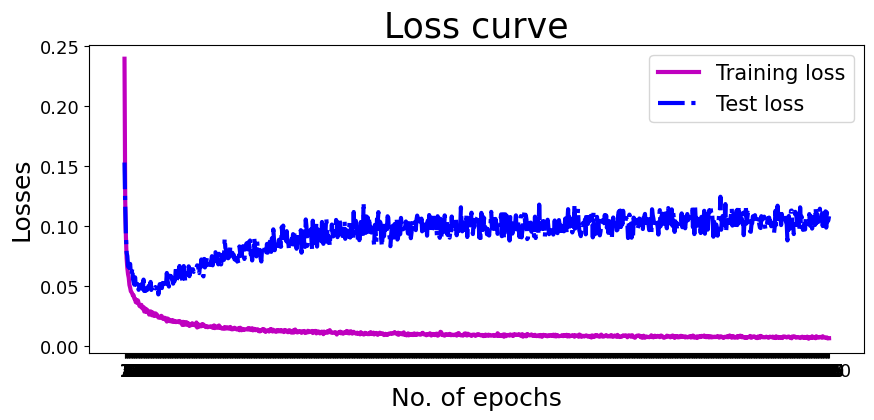

In [43]:
N = np.arange(n_epochs) + 1

plt.figure(figsize=(10, 4))
plt.plot(N, training_loss, 'm-', linewidth=3, label='Training loss')
plt.plot(N, test_loss, 'b-.', linewidth=3, label='Test loss')
plt.title('Loss curve', fontsize=25)
plt.xlabel('No. of epochs', fontsize=18)
plt.ylabel('Losses', fontsize=18)
plt.xticks(N, fontsize=13)
plt.yticks(fontsize=13)
plt.legend(fontsize=15);

In [44]:
_, collect = ddpm.ddpm_sampling(model=model, num_samples=1, channels=1, img_size=32)

1000it [00:05, 174.75it/s]


In [45]:
step = [1000, 900, 800, 700, 600, 500, 400, 300, 200, 100, 1]

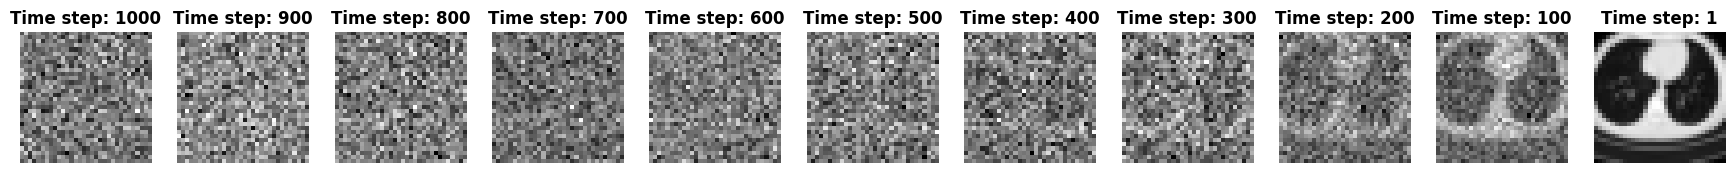

In [46]:
fig, axis = plt.subplots(nrows=1, ncols=11, figsize=(22, 2))

j = 0
for ax, _ in zip(axis.ravel(), range(11)):
    ax.imshow(collect[j][0].detach().cpu().permute(1, 2, 0), cmap='gray')
    ax.set_title(f'Time step: {step[j]}', fontweight='bold')
    ax.axis(False)
    j += 1;

In [47]:
sampled_imgs, _ = ddpm.ddpm_sampling(model=model, num_samples=64, channels=1, img_size=32)

1000it [01:08, 14.68it/s]


In [48]:
grid = make_grid(sampled_imgs.detach().cpu(), nrow=16, normalize=True)

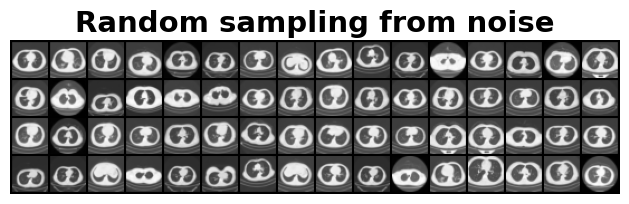

In [49]:
plt.figure(figsize=(12, 2))
plt.imshow(grid.permute(1, 2, 0), cmap='gray')
plt.axis(False)
plt.title('Random sampling from noise', fontsize=21, fontweight='bold');

In [50]:
import os
from torchvision.utils import save_image

# Define the path to save the sampled images
save_path = "YourPath"

# Create the directory if it doesn't exist
os.makedirs(save_path, exist_ok=True)

# Iterate through the sampled images and save each one individually
for i, img in enumerate(sampled_imgs):
    # Generate the file name
    filename = os.path.join(save_path, f"sampled_image_{i}.jpg")
    # Save the image
    save_image(img, filename)

print("Sampled images saved successfully!")


Sampled images saved successfully!
